Exception ignored in: <function Viewer.__del__ at 0x000002951502A9D8>
Traceback (most recent call last):
  File "C:\Users\45937\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 162, in __del__
    self.close()
  File "C:\Users\45937\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 81, in close
    self.window.close()
  File "C:\Users\45937\anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\45937\anaconda3\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\45937\anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x0000029519BAD368; to 'Win32Window' at 0x00000295175A8148>,)


(506, 13) (506, 1)
(20, 506) (506, 1)
110.58049674804326 168.29717660792846


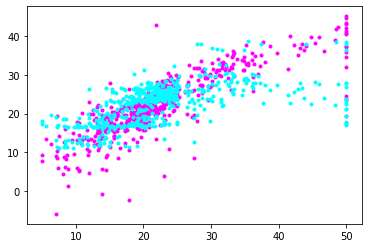

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
rawData = np.genfromtxt('housing.data')
N, pp1 = rawData.shape

# Last colum is target
X = np.matrix(rawData[:,0:pp1-1])
y = np.matrix(rawData[:,pp1-1]).T
print(X.shape, y.shape)

# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T*X)) * X.T * y
yh_lin = X*w
plt.plot(y, yh_lin, '.', Color='magenta')

# J = 20basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data

from sklearn.cluster import KMeans

J = 20;
kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
sig = np.std(X)

# Construct design matrix
U = np.zeros((N,J))
for i in range(N):
    for j in range(J):
        U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
        
# Solve RBF model, predict and plot
w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y
yh_rbf = np.dot(U,w)

print(np.dot((np.linalg.inv(np.dot(U.T,U))), U.T).shape,y.shape)
plt.plot(y, yh_rbf, '.', Color='cyan')

print(np.linalg.norm(y-yh_lin), np.linalg.norm(y-yh_rbf))

In [22]:
w.shape

(20, 1)

786.058654420887


Text(0.5, 1.0, 'Stochastic Gradient Descent on RBF')

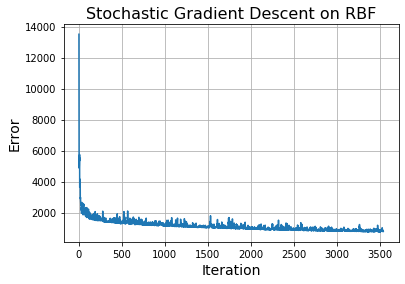

In [26]:
MaxIter = 7 * N
Eplot = np.zeros((MaxIter,1))
w = np.random.randn(20,1)
lr = 0.0000002

for i in range(MaxIter):
    j = np.floor(np.random.rand()*N).astype(int)
    yPred = U[j,:].T @ w
    uj = np.array([U[j,:]]).T
    yj = y[j,:]
    w = w - (lr * (yPred - yj) * uj.T).T
    Eplot[i] = np.linalg.norm(y - U @ w)

print(np.linalg.norm(y - U @ w))
fig, ax = plt.subplots()
ax.plot(Eplot)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_ylabel("Error", fontsize=14)
ax.grid(True)
ax.set_title("Stochastic Gradient Descent on RBF",fontsize=16)

In [1]:
import gym
import numpy as np
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
env.render()

# Some initializations
#
n_states = 40
episodes = 40
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped
env.seed()
np.random.seed(0)

# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0

for episode in range(episodes):
    print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        
        # Q function update
        # 
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        
        steps +=1
        if terminate:
            break
# while True:
#     env.render()
    

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39


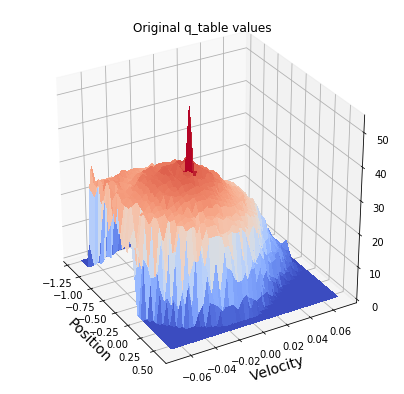

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

pos_3d = np.linspace(-1.2, 0.6, 40)
vel_3d = np.linspace(-0.07, 0.07, 40)
pos_grid, vel_grid = np.meshgrid(pos_3d, vel_3d)
q_table_z = np.max(q_table,2)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(pos_grid, vel_grid, -q_table_z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('Original q_table values')
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.view_init(30,-30)

In [4]:
def getWeightsRBF(env, obs, qtable, J):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    N = n_states ** 2
    obs_table = np.zeros((N,2))
    y_0 = np.zeros(N)
    y_1 = np.zeros(N)
    y_2 = np.zeros(N)
    
    for i in range(n_states):
        for j in range(n_states):
            obs_table[i*n_states + j][0] = i * pos_den + pos_low
            obs_table[i*n_states + j][1] = j * vel_den + vel_low
            y_0[i*n_states + j] = qtable[i][j][0]
            y_1[i*n_states + j] = qtable[i][j][1]
            y_2[i*n_states + j] = qtable[i][j][2]
            
    y_0 = np.matrix(y_0).T
    y_1 = np.matrix(y_1).T
    y_2 = np.matrix(y_2).T

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=J, random_state=0).fit(obs_table)
    sig = np.std(obs_table)

    # Construct design matrix
    U = np.zeros((N,J))

    for i in range(N):
        for j in range(J):
            U[i][j] = np.linalg.norm(obs_table[i] - kmeans.cluster_centers_[j])

    w_0 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_0
    w_1 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_1
    w_2 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_2

    return kmeans,w_0,w_1,w_2

def chooseAction(w_0,w_1,w_2,obs,kmeans):
    input_pos = obs[0]
    input_vel = obs[1]

    u = np.zeros(kmeans.n_clusters)
    for j in range(kmeans.n_clusters):
        u[j] = np.linalg.norm([input_pos,input_vel] - kmeans.cluster_centers_[j])

    val = np.zeros(3)    
    val[0] = np.dot(u,w_0)
    val[1] = np.dot(u,w_1)
    val[2] = np.dot(u,w_2)

    action_num = np.argmax(val)
    return action_num

In [5]:
def getZRBF(w_0,w_1,w_2,kmeans):
    q_table_rbf = np.zeros((40, 40, 3))
    
    for i in range(40):
        for j in range(40):
            u = np.zeros(kmeans.n_clusters)
            for k in range(kmeans.n_clusters):
                u[k] = np.linalg.norm([-1.2+i*(1.8/40),-0.07+j*(0.14/40)] - kmeans.cluster_centers_[k])
            
            q_table_rbf[i][j][0] = np.dot(u,w_0)
            q_table_rbf[i][j][1] = np.dot(u,w_1)
            q_table_rbf[i][j][2] = np.dot(u,w_2)
    return q_table_rbf

In [8]:
J_cal_acc = [2,10,20,200]
kmeans_cal_acc = []
w0_cal_acc = []
w1_cal_acc = []
w2_cal_acc = []

for i in range(len(J_cal_acc)):
    kmeans_temp,w0_temp,w1_temp,w2_temp = getWeightsRBF(env, obs, q_table, J_cal_acc[i])
    kmeans_cal_acc.append(kmeans_temp)
    w0_cal_acc.append(w0_temp)
    w1_cal_acc.append(w1_temp)
    w2_cal_acc.append(w2_temp)


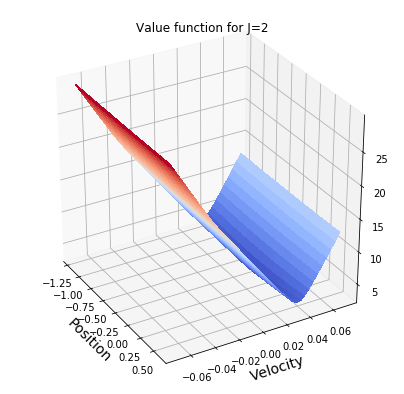

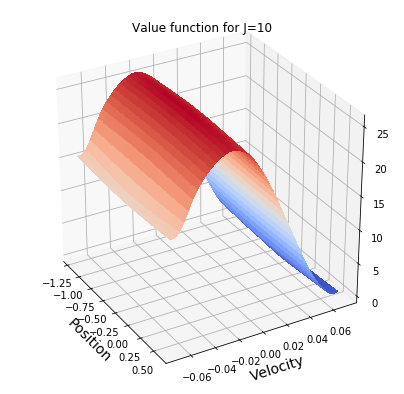

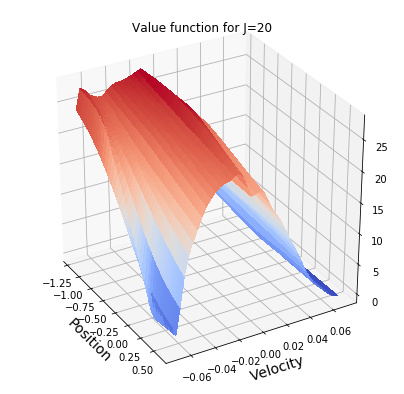

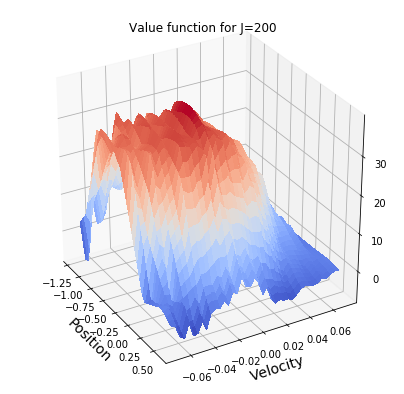

In [12]:
for i in range(len(J_cal_acc)):
    
    q_ = getZRBF(w0_cal_acc[i],w1_cal_acc[i],w2_cal_acc[i],kmeans_cal_acc[i])

    pos_3d = np.linspace(-1.2, 0.6, 40)
    vel_3d = np.linspace(-0.07, 0.07, 40)
    pos_grid, vel_grid = np.meshgrid(pos_3d, vel_3d)
    q_ = np.max(q_,2)

    fig = plt.figure(figsize=(7,7))
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(pos_grid, vel_grid, -q_, cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    ax.set_title('Value function for J={}'.format(J_cal_acc[i]))
    ax.view_init(60,45)
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Velocity', fontsize=14)
    ax.view_init(30,-30)

In [ ]:
J_cal_acc = [2,10,20,200]
kmeans_cal_acc = []
w0_cal_acc = []
w1_cal_acc = []
w2_cal_acc = []
right_count = np.zeros(len(J_cal_acc))
total_count = 0

for i in range(len(J_cal_acc)):
    kmeans_temp,w0_temp,w1_temp,w2_temp = getWeightsRBF(env, obs, q_table, J_cal_acc[i])
    kmeans_cal_acc.append(kmeans_temp)
    w0_cal_acc.append(w0_temp)
    w1_cal_acc.append(w1_temp)
    w2_cal_acc.append(w2_temp)
    
    
for episode in range(episodes):
    print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    while True:
        env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
            total_count +=1
            for i in range(len(J_cal_acc)):
                if a == chooseAction(w0_cal_acc[i], w1_cal_acc[i], w2_cal_acc[i], obs, kmeans_cal_acc[i]):
                    right_count[i] += 1
            
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        
        if terminate:
            break

In [1]:
import gym
import numpy as np
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
env.render()

# Some initializations
#
n_states = 40
episodes = 10
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped
env.seed()
np.random.seed(0)

# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

def getWeightsRBF(env, obs, qtable, J):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    N = n_states ** 2
    obs_table = np.zeros((N,2))
    y_0 = np.zeros(N)
    y_1 = np.zeros(N)
    y_2 = np.zeros(N)
    
    for i in range(n_states):
        for j in range(n_states):
            obs_table[i*n_states + j][0] = i * pos_den + pos_low
            obs_table[i*n_states + j][1] = j * vel_den + vel_low
            y_0[i*n_states + j] = qtable[i][j][0]
            y_1[i*n_states + j] = qtable[i][j][1]
            y_2[i*n_states + j] = qtable[i][j][2]
            
    y_0 = np.matrix(y_0).T
    y_1 = np.matrix(y_1).T
    y_2 = np.matrix(y_2).T

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=J, random_state=0).fit(obs_table)
    sig = np.std(obs_table)

    # Construct design matrix
    U = np.zeros((N,J))

    for i in range(N):
        for j in range(J):
            U[i][j] = np.linalg.norm(obs_table[i] - kmeans.cluster_centers_[j])

    w_0 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_0
    w_1 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_1
    w_2 = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) * y_2

    return kmeans,w_0,w_1,w_2
    
    
def chooseAction(w_0,w_1,w_2,obs,kmeans):
    input_pos = obs[0]
    input_vel = obs[1]

    u = np.zeros(kmeans.n_clusters)
    for j in range(kmeans.n_clusters):
        u[j] = np.linalg.norm([input_pos,input_vel] - kmeans.cluster_centers_[j])

    val = np.zeros(3)    
    val[0] = np.dot(u,w_0)
    val[1] = np.dot(u,w_1)
    val[2] = np.dot(u,w_2)

    action_num = np.argmax(val)
    return action_num



q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0

for episode in range(episodes):
    print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        
        # Q function update
        # 
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        steps +=1
        if terminate:
            break

kmeans,w0,w1,w2 = getWeightsRBF(env, obs, q_table, J=20)         
            
# build RBF
for episode in range(episodes):
    print("RBF Epsisode:", episode)
    obs = env.reset()
    total_reward = 0
    while True:
        env.render()
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = chooseAction(w0, w1, w2, obs, kmeans)
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        
        if terminate:
            break

# while True:
#     env.render()

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
RBF Epsisode: 0
RBF Epsisode: 1
RBF Epsisode: 2
RBF Epsisode: 3
RBF Epsisode: 4
RBF Epsisode: 5
RBF Epsisode: 6
RBF Epsisode: 7
RBF Epsisode: 8
RBF Epsisode: 9


In [2]:
J_cal_acc = [2,10,20,200]
kmeans_cal_acc = []
w0_cal_acc = []
w1_cal_acc = []
w2_cal_acc = []
right_count = np.zeros(len(J_cal_acc))
total_count = 0

for i in range(len(J_cal_acc)):
    kmeans_temp,w0_temp,w1_temp,w2_temp = getWeightsRBF(env, obs, q_table, J_cal_acc[i])
    kmeans_cal_acc.append(kmeans_temp)
    w0_cal_acc.append(w0_temp)
    w1_cal_acc.append(w1_temp)
    w2_cal_acc.append(w2_temp)
    

    
for episode in range(episodes):
    print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    while True:
        env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
            total_count +=1
            for i in range(len(J_cal_acc)):
                if a == chooseAction(w0_cal_acc[i], w1_cal_acc[i], w2_cal_acc[i], obs, kmeans_cal_acc[i]):
                    right_count[i] += 1
            
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        
        if terminate:
            break

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9


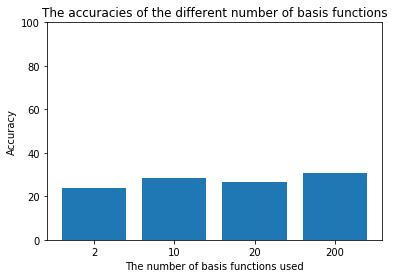

In [3]:
acc = right_count / total_count * 100

import matplotlib.pyplot as plt
import matplotlib

x = range(len(acc))
rects = plt.bar(x, acc)
plt.ylim(0,100)
plt.ylabel("Accuracy")
plt.xticks(x,J_cal_acc)
plt.xlabel("The number of basis functions used")
plt.title("The accuracies of the different number of basis functions")
plt.show()

In [4]:
pos_3d = np.linspace(-1.2, 0.6, 40)
vel_3d = np.linspace(-0.07, 0.07, 40)
pos_grid, vel_grid = np.meshgrid(pos_3d, vel_3d)
q_table_z = np.max(q_table,2)

# fig = plt.figure(figsize=(7,7))
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(pos_grid, vel_grid, -q_table_z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
# ax.set_title('Value function for J={}'.format(J))
# ax.view_init(60,45)
# ax.set_xlabel('Position', fontsize=14)
# ax.set_ylabel('Velocity', fontsize=14)
# ax.set_zlabel('- Q*', fontsize=14)
# ax.view_init(30,-30)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
Z = np.max(q_table, 2)
surf = ax.plot_surface(pos_grid, vel_grid, -q_table_z, cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)
ax.set_title('Original q_table values')
ax.view_init(60,45)
ax.set_xlabel('Position', fontsize=14)
ax.set_ylabel('Velocity', fontsize=14)
ax.view_init(30,-30)

ValueError: Unknown projection '3d'

<Figure size 504x504 with 0 Axes>

In [3]:
env_name = "MountainCar-v0"
env = gym.make(env_name)

obs = env.reset()
#env.render()
n_states   = 40
episodes   = 10000
initial_lr = 1.0
min_lr     = 0.005
gamma      = 0.99
max_stps   = 300
epsilon    = 0.2

env = env.unwrapped
env.seed()
np.random.seed(0)

# random.seed(7)
#  27 and 39
first_index = random.randint(15, n_states - 1)
second_index = random.randint(15, n_states - 1)
action_values = []
# 40 x 40 x 3 = 4800 possible options
total_steps = 0
for episode in range(episodes):
    #print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        #env.render()
        pos, vel = obs
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
             a = np.argmax(featurizer(np.array([pos]), np.array([vel]), J, means) @ w_action)
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        print(pos)
#         pos_, vel_ = discretization(env, obs)
        steps += 1
        if terminate:
            break
            
    action_values.append((q_table[first_index][second_index][0], q_table[first_index][second_index][1], q_table[first_index][second_index][2]))
print("FINISHED")        
#while True:
#    env.render()

-0.42664473202445596
-0.4283616776499973
-0.4317832232293891
-0.4368847107685532
-0.44362924321927233
-0.4519678102758979
-0.46183948430493726
-0.47317170748080856
-0.48588069272489354
-0.49987196030443254
-0.515041028767229
-0.5312742732808137
-0.5484499566487667
-0.566439428771613
-0.5851084798121184
-0.6033188217003819
-0.6219369467058143
-0.640828187370069
-0.6598582200337306
-0.6788945311602831
-0.6978078030795074
-0.7164731793659094
-0.7347713761887334
-0.7525896140431297
-0.7698223535646147
-0.7863718288486508
-0.8021483810877224
-0.8170706037597902
-0.8290653175849063
-0.8400764931874739
-0.8500549546683516
-0.8589580524844155
-0.8657493020790352
-0.8714018846686414
-0.8758941545524488
-0.8792093519992268
-0.8813353620944887
-0.8822645295241792
-0.8819935365975
-0.8805233491586668
-0.875859232410539
-0.8700181719916267
-0.8630220403968886
-0.8528979057615019
-0.8416865949988387
-0.8294355640210047
-0.8161993058306426
-0.8020397068939471
-0.7870263251443598
-0.771236562932373
-0

-0.2532335548217182
-0.2536268979331029
-0.2568308135466756
-0.2628286486034894
-0.2705887837149437
-0.2810694638577014
-0.2922128197201476
-0.30395552160671974
-0.3162289010464772
-0.32895915759512745
-0.3440676583820289
-0.35945848164117683
-0.37703120622686487
-0.3966681069898507
-0.4182341474048441
-0.4415773286877313
-0.46652948183031223
-0.49290756670982905
-0.5205155105609135
-0.5481465785700295
-0.5765937044259477
-0.6056450405863595
-0.6350872243598463
-0.6647087476572656
-0.6943032742137292
-0.7236727490274651
-0.7526301597956848
-0.7810018371271531
-0.8076292156191689
-0.8333749466181312
-0.8581176318108955
-0.8817518488010619
-0.9041877339033226
-0.9253501942188865
-0.9451778292042127
-0.9636216432963273
-0.9806436270798355
-0.9962152765702388
-1.0103161100166709
-1.0229322305658621
-1.0340549722554389
-1.0436796568763367
-1.0518044807212223
-1.0584295433300532
-1.0635560250781322
-1.0671855167183157
-1.0693195015980212
-1.0699589899900548
-1.0691043045525597
-1.06575501611

-0.9984214711946086
-0.9764037865240821
-0.9529422725088303
-0.9270800399713185
-0.8988783759913229
-0.8694201396412891
-0.8368091089720077
-0.8031797272684229
-0.7686908369792815
-0.7335249666602633
-0.6968866817798851
-0.6590064922355838
-0.6201384460278783
-0.5805564320095199
-0.5415493113169827
-0.5034076266677139
-0.4664172830471598
-0.4298537003274186
-0.39498397400247165
-0.3620551016670187
-0.3312909340864267
-0.30289038648231587
-0.2770268247079171
-0.2538484580598725
-0.23147951767240751
-0.21103161009292262
-0.19359920335983014
-0.1792568598129241
-0.16806164820157968
-0.15905535787411318
-0.15226981756521318
-0.14672793818590757
-0.14244774219175507
-0.13944272137685484
-0.1377221239931765
-0.13729116181458928
-0.13815113069839494
-0.14029944100864417
-0.14572955699722678
-0.1544245368413956
-0.1643560026496782
-0.17748968051885416
-0.19177724903565255
-0.20716234715401682
-0.22557997910674338
-0.244946657278894
-0.2651681805928795
-0.28813951516414077
-0.3117335561061126
-

-0.41909915542653375
-0.3830585672491064
-0.3490410783010367
-0.31727375024901017
-0.28795692392693184
-0.26126384548533943
-0.23534137185598053
-0.2103212669539986
-0.18831981033921988
-0.1694298795269489
-0.15272389419025845
-0.13826006554731307
-0.12508424920658848
-0.11323447041006975
-0.10374182544502261
-0.09762907801181551
-0.09490986625772731
-0.09558999861087042
-0.09966803721937759
-0.10513515162902799
-0.11197894274908511
-0.12018298860664985
-0.13072629270459402
-0.14257979300451165
-0.15770805783734243
-0.17406169528043677
-0.19258216118114024
-0.2121968658466227
-0.23282188844150659
-0.2543614853667498
-0.27870785133739673
-0.3057300782393603
-0.33327243818158675
-0.36116593817721615
-0.38923003957872526
-0.4192748346455708
-0.45108934834204695
-0.4844434040770104
-0.519090450217792
-0.5547713077680801
-0.5912187119539296
-0.6281624378451509
-0.6653347347336763
-0.7024757562291969
-0.7393386692025374
-0.7756941554198005
-0.8113340797361007
-0.8460741782469298
-0.879755706

-0.38477794960138695
-0.41319025382352575
-0.4434155635992601
-0.47523646455702356
-0.5084188116397967
-0.5407149691045262
-0.5738828115228586
-0.6066749523970886
-0.6398504522732595
-0.673171632021437
-0.7064082834778194
-0.739341567779326
-0.7717674079819751
-0.803499226887913
-0.8343699364149109
-0.8642331437597552
-0.8929635948587193
-0.9204569216108875
-0.9456287925889708
-0.9674158257800886
-0.9877741254214207
-1.0066720453318887
-1.023088418557946
-1.036011327999487
-1.0474356450393
-1.0553599627168608
-1.0617850298877898
-1.0667124906151941
-1.0701442344886976
-1.0720818997138135
-1.0715265280507107
-1.0694778122971418
-1.0659346790775794
-1.0608954944677085
-1.0543584204393612
-1.046321923266872
-1.0367854347200256
-1.025750165710922
-1.0132200698081368
-0.999202950442719
-0.9837117005077588
-0.9667656562739251
-0.9483920391102781
-0.927627448599202
-0.9045219821617649
-0.8801420492552519
-0.8545695595681007
-0.8279030188589311
-0.8002582579907247
-0.7717687050588659
-0.740585

-1.1845523006941028
-1.184239761300599
-1.182635544018317
-1.1797348670567458
-1.1755292192996145
-1.1690065707703856
-1.1611489941469626
-1.1519360808977919
-1.1393455698741404
-1.1253499786872372
-1.1099227860851524
-1.0930397256449518
-1.0746802698962887
-1.0548293064583647
-1.0334789982333128
-1.0106308069447554
-0.9862976432531071
-0.9585060876174714
-0.9283025056042526
-0.8947562750398382
-0.8589669510537306
-0.8220657431295396
-0.7842133857288967
-0.7455995557608234
-0.7054411068398134
-0.6639854862557749
-0.6215078169665073
-0.5783063433658929
-0.5356964025494588
-0.49399574944791674
-0.45351682730679943
-0.4145596560092609
-0.3754057711746421
-0.33832708097766206
-0.3035674804437301
-0.2713408574549435
-0.2418306828782248
-0.21319094089270574
-0.18755707588979273
-0.16503779381352188
-0.1447182988482691
-0.1266668685175163
-0.11093709921417474
-0.0985701489729735
-0.08959468709587724
-0.08402946150101785
-0.08088521999268213
-0.08116773671696963
-0.08487650167611711
-0.0920046

-0.3729728371848068
-0.3539868374187083
-0.33721873985217277
-0.3227767859183618
-0.31075152200107736
-0.3012163209821366
-0.2942279887267043
-0.28982735700798257
-0.28803978111135714
-0.28787548053395384
-0.29033539223721694
-0.2934054468679421
-0.29706796246660494
-0.30330166822475924
-0.3100699258476244
-0.31733234798867127
-0.3250449138899395
-0.3351601210975104
-0.34661453492621364
-0.36033483657227017
-0.37623124369668015
-0.3941972529438551
-0.4141095801707182
-0.43582838969814186
-0.45919789674151223
-0.4840474110941952
-0.510192865126081
-0.5364388363841962
-0.5635885309998245
-0.5904390213793157
-0.6177915626060533
-0.6454470221450315
-0.6732088364446783
-0.700885871049352
-0.7262950596649704
-0.7512759984147059
-0.7736790684807779
-0.7953776010756711
-0.8162562428306896
-0.8362112710634766
-0.85515059732498
-0.8729934952960183
-0.8896700975516559
-0.9051207103050567
-0.9192949963752827
-0.930151074927961
-0.9396596999918898
-0.9477972999545798
-0.9545452332769685
-0.95888912

-0.28543630808862774
-0.2778866777647339
-0.27301747342197547
-0.27085555337888984
-0.2714127262479454
-0.2746859555950097
-0.28065730670766514
-0.2892936407011616
-0.29954608662163434
-0.3103552227403468
-0.3236568073142792
-0.33736963883299376
-0.35340765445750005
-0.36966736399798183
-0.38804096133866695
-0.4084034493623907
-0.43061280755944037
-0.45451055072342317
-0.47992275361379266
-0.5066615901665558
-0.5345274009562793
-0.5633112617391897
-0.5927979829617582
-0.6227694299326088
-0.6530080209487067
-0.6833002403749844
-0.7134399983193448
-0.743231678855475
-0.7724927432175607
-0.8010557895861603
-0.8287700123195276
-0.8555020457081461
-0.8801362159752243
-0.903577850481448
-0.9257479667884613
-0.9465821930326397
-0.9660294460037394
-0.9840504514062881
-1.00061618281526
-1.01570628504384
-1.0293075356001165
-1.0414123858845943
-1.0510176126761703
-1.0591230036357338
-1.0657299943593304
-1.070840847916559
-1.0734579876492674
-1.0745828814886258
-1.074216207592057
-1.0723577417877

-0.3471841044242097
-0.3364483029768244
-0.3280435399274165
-0.32202274521724755
-0.3184232965311561
-0.31726731890067733
-0.3185618822860999
-0.3222990679694841
-0.32845589429801
-0.33699411236951243
-0.3458599019173733
-0.3569964565765132
-0.37033115153205076
-0.38577527514129395
-0.4032238732259608
-0.4225557878607879
-0.44363397241532215
-0.46630615712257467
-0.4904059239182909
-0.5157542258847637
-0.5421613565435288
-0.5694293397901462
-0.5973546757564169
-0.6257313452400515
-0.6533539495190629
-0.6800277813304243
-0.7065709868981256
-0.7328097841503018
-0.7585805050800135
-0.7837312458011031
-0.8081230818015968
-0.8316308336249291
-0.8541433942398327
-0.8755636514984814
-0.895808055920343
-0.9148058950003491
-0.9324983404898847
-0.9468373353613202
-0.959788788787273
-0.9713257040917928
-0.981427101322518
-0.9900770055852471
-0.9962635261269798
-0.9989791755190369
-1.0002209357146945
-0.9999874813741405
-0.9982790590435451
-0.9950975098922867
-0.9904464357846703
-0.984331506993130

-0.235518936605756
-0.24082814422958962
-0.2490127648878453
-0.26003164672110296
-0.27382764546772437
-0.2883264847513002
-0.3044469634169253
-0.3210952037922394
-0.338170507542898
-0.35556589834508434
-0.373168835120812
-0.3928620883664091
-0.4135109205896405
-0.4359704837149013
-0.46007971532307446
-0.4856624619801552
-0.5125291171755842
-0.5404787795500023
-0.5693018959969257
-0.5967833119967214
-0.6247202430722549
-0.6529103424866126
-0.6811547484220312
-0.7092609961017293
-0.737045666972155
-0.7643366661926558
-0.7909750471478156
-0.8168163340435937
-0.841731327104103
-0.8656064059837294
-0.8863433730536164
-0.9058658184065603
-0.9241096323255703
-0.9410219629199144
-0.9565600489684717
-0.9706899874959336
-0.9833854882739215
-0.9936266590883412
-1.002400046176858
-1.0096959759905084
-1.0155077107645167
-1.0188307347991346
-1.0206628059798226
-1.0210027940214497
-1.0198504974509908
-1.0172066096026968
-1.0130728338166193
-1.0074521471766347
-1.000349211084158
-0.9917709255034051
-0

-0.24235793028083846
-0.21944505150462934
-0.1995097024310069
-0.18263976648310762
-0.16890385611385084
-0.1573538085531829
-0.14803034300026185
-0.1409643813628174
-0.13517818325239833
-0.13068921425005273
-0.12751054772154968
-0.12565118774880543
-0.12711630355160625
-0.12990182798509356
-0.13599990489690786
-0.14339277260848068
-0.152057868819376
-0.16296732666496275
-0.1750839072186872
-0.1883634821425156
-0.20275440749264656
-0.21819693715398214
-0.2346227096220248
-0.25195434347638845
-0.27210517694841746
-0.2949682865573761
-0.3184148039892042
-0.34430484448044407
-0.37047568006010906
-0.3987549728057681
-0.42894885670345984
-0.4608431141466138
-0.4942052635485715
-0.528787578704114
-0.5643309794079874
-0.6005696482830611
-0.637236152123123
-0.6740667887939196
-0.7108068520438566
-0.7472155112106531
-0.7830700399448114
-0.8181691914816517
-0.8523355975401623
-0.8854171518444179
-0.917287416578098
-0.947845152502841
-0.9770131163685141
-1.0047362916761307
-1.0309797228549387
-1.0

-0.2629348206296523
-0.2646804469414069
-0.26817849524326387
-0.2744101585360017
-0.2823414610857624
-0.29092830299376665
-0.30012188355908404
-0.3098687728811696
-0.3211110360001982
-0.3327802649976503
-0.3448037383310607
-0.3571047919599835
-0.37160327269752735
-0.3872026240404241
-0.40479663766253443
-0.424262923134651
-0.44546324902729734
-0.4662442395069666
-0.4884532696073198
-0.5119254028894412
-0.5364850685725695
-0.5619481111299417
-0.5861241677429078
-0.6108340290120371
-0.6358970687644365
-0.6611337132110787
-0.6863678654050079
-0.7094291884418813
-0.7321678640598495
-0.7534423629460791
-0.7741264237966755
-0.794103494326061
-0.8132672389754173
-0.8315217656042034
-0.8487815940284156
-0.864971398604498
-0.8800255633211482
-0.893887591132587
-0.905509409881829
-0.9158536982117402
-0.9248895645528503
-0.9325918427025545
-0.9389404337563282
-0.943919715532963
-0.9465180364425566
-0.9477295271684157
-0.9475515006411279
-0.9459843497435294
-0.9430315623775875
-0.9386998535785563


-0.26830377884631096
-0.27928664584390067
-0.29094215003892343
-0.30320431332595404
-0.31600160483508927
-0.32925715845780446
-0.34288909108311094
-0.3568109260402363
-0.37293212237459106
-0.3911452325112101
-0.4093258075660731
-0.4293467408675112
-0.45106518258024925
-0.474323343302069
-0.49894972523976705
-0.5247608066193719
-0.551563172783971
-0.5791560519022642
-0.6073341779620463
-0.6358908728017618
-0.6636212161933173
-0.6913320047775905
-0.7188372156878081
-0.7459604375676333
-0.7715369131956628
-0.7964206392652876
-0.8204791199272397
-0.8435939129349114
-0.8656607479383084
-0.8865892599504549
-0.9063023950685073
-0.9247355536331967
-0.9418355386363824
-0.957559375274826
-0.9718730622680292
-0.9847503081147465
-0.9961712969539983
-1.006121520023394
-1.0145907005390291
-1.0215718325953693
-1.0260603486353186
-1.0290538892812404
-1.030551132428162
-1.030551492338904
-1.0290549688787216
-1.0240621474790428
-1.0175753451901823
-1.0095984080012206
-1.00013735803192
-0.989201181651505

-0.8785817116210326
-0.8657945449648906
-0.8518685356031244
-0.8368596096582923
-0.8208321092042214
-0.8018592571873959
-0.7820335306589966
-0.7614579705895964
-0.7402460537755879
-0.7185212867112657
-0.6964165057540774
-0.6730728818144472
-0.6486453969378981
-0.6233019053862524
-0.5982217406927715
-0.5735865669357061
-0.5495778883845008
-0.5263745636813404
-0.5041504208081651
-0.4830720578536884
-0.46229689701660887
-0.44197891301276676
-0.423266979267024
-0.40629622300010726
-0.3911871896934823
-0.3780453311365849
-0.3669607613957617
-0.3580082157719907
-0.3512471449668066
-0.3457218795750092
-0.3424682706475115
-0.34150726662231184
-0.3428450314768731
-0.346472981716928
-0.3523677351467493
-0.3604909812310156
-0.36878929926319703
-0.3792073969097378
-0.3916748792526259
-0.4061061624467392
-0.4224005065588572
-0.4404422320215451
-0.46010118259200483
-0.48123349012023964
-0.5036826825532339
-0.5272811568279261
-0.551852013805137
-0.575211225126141
-0.597184887957708
-0.619611126740572

-0.683865416934832
-0.658945710476907
-0.6330385661369352
-0.6073252902322217
-0.5799906476734622
-0.553235080635753
-0.527257534030696
-0.5022525472883953
-0.4774075478560008
-0.45390787495234863
-0.4319270842591432
-0.4116251971772865
-0.39314740655110064
-0.37662321715527936
-0.36216597199222894
-0.3498726957451426
-0.3398241752270529
-0.3320851930677667
-0.3267048342391313
-0.323716794032769
-0.32313962938530455
-0.32497691170419796
-0.32921725748029446
-0.33583423206948054
-0.34278614130134605
-0.3520286142137267
-0.36350179428826646
-0.37613006741726174
-0.39082862848419164
-0.40749684355275667
-0.42601832318937993
-0.4462612479162965
-0.4680790142556659
-0.4913112561877221
-0.515785276026738
-0.5413178917462106
-0.566717676671947
-0.5917949709795135
-0.6153643544284979
-0.6392541565983014
-0.6632938429898976
-0.687316216904541
-0.7111594850473268
-0.7346691113613103
-0.757699396929052
-0.7801147411426547
-0.8017905588620988
-0.8226138480086557
-0.8414834202292948
-0.859314153696

-0.7579131881553381
-0.7297146904982597
-0.7010669687585365
-0.6711502306040975
-0.6411626436924083
-0.6103114943259235
-0.5798173098039666
-0.5499034823345239
-0.5207925742644863
-0.4917027124558487
-0.4638517062282748
-0.4374464074740583
-0.4116800817388885
-0.3877374638213969
-0.36578582676267657
-0.3449740636239351
-0.3264387825758363
-0.30829747699765225
-0.29266097265882446
-0.2796212295462951
-0.26925225778671896
-0.2616110896198267
-0.2567386867256915
-0.25466068444593737
-0.2553878995394014
-0.25691655454492607
-0.26123868105208886
-0.2683315456064161
-0.2781571979131356
-0.28966177345650146
-0.30278035341027176
-0.3164365699727943
-0.33054839764403776
-0.34502850955181313
-0.35978475242939806
-0.3767207397662129
-0.3957230098260427
-0.4156609962974133
-0.43739444281903983
-0.4607672391420002
-0.4856084864188694
-0.5117340444282121
-0.5389485691325446
-0.5670480110684751
-0.5958225057363975
-0.6250595507963217
-0.6545473359784639
-0.6840780739894159
-0.7134511767417522
-0.7424

-0.9126116731921153
-0.915583391086372
-0.9152474660612021
-0.9136048684222153
-0.9106603764608314
-0.9054226954902364
-0.8989077523716364
-0.8911361420605002
-0.8821335588581533
-0.8719312819096502
-0.860566696729401
-0.8480838311117475
-0.8345338805199263
-0.8179756951858729
-0.7994856851895327
-0.7801547986030585
-0.7600841697578692
-0.7393849877522289
-0.7181781018707616
-0.6965933490379099
-0.6737686013690548
-0.6498552931126759
-0.6250175410666088
-0.6004308297384878
-0.5752729669300436
-0.5497290981150509
-0.524989452537756
-0.5012393769136725
-0.4786568710508062
-0.4574104092088909
-0.4376571044379901
-0.41854124481785593
-0.39920033661468557
-0.3807709100670461
-0.36438021343167093
-0.3501387630821717
-0.33814033749724104
-0.3284621911165925
-0.32116539711685277
-0.31529523420777883
-0.31188763327396246
-0.31096324465853337
-0.31252764359562757
-0.31657138809301394
-0.32306992151266434
-0.3319833329536358
-0.34125600895422703
-0.3518290636487067
-0.36463412800362804
-0.3775867

-0.55516158414472
-0.5828571846175018
-0.6111106843319318
-0.639715358488481
-0.6674666647945825
-0.6951721512390016
-0.7226469095378042
-0.7477159594677399
-0.772227940733988
-0.796043362173972
-0.8190354729453878
-0.8410907237411098
-0.8621088416190418
-0.882002559058419
-0.9006970498053501
-0.9171291308526758
-0.9322491343937331
-0.9460163184919511
-0.9583977944440085
-0.9693674577101985
-0.9789049590751351
-0.9869947457952595
-0.9936251960498675
-0.9987878643344811
-1.0024768506631123
-1.0046883026008568
-1.0054200561593223
-1.0046714193180488
-1.0024431002050946
-0.9987372805724102
-0.993557833915493
-0.9869106861867049
-0.978804315316624
-0.9692503834812018
-0.9582644930544659
-0.9458670533310733
-0.931084240320094
-0.914951575679927
-0.8975130950336903
-0.8788224682601491
-0.8589440568084681
-0.8359538533135425
-0.8119490904814811
-0.787041506880952
-0.7613574627007742
-0.7330376317489683
-0.7042483416352002
-0.6741695354472167
-0.6429994624770424
-0.6109529120592089
-0.57925867

-0.2504463786502253
-0.24410056041960826
-0.24061383596021918
-0.2400035869833657
-0.2422728345902418
-0.24741031287387003
-0.2553901972258054
-0.2661715095410541
-0.27969725073682816
-0.29389333910989296
-0.3086790659603789
-0.32396730766348136
-0.33966487346801305
-0.355672995219095
-0.3738879595680338
-0.3931883843817697
-0.4144421263213947
-0.43749998940436785
-0.46219643698139407
-0.4873508021156909
-0.5137764915665739
-0.541275837487353
-0.5696426675768751
-0.5986652655968997
-0.6281296116172533
-0.6578227628212364
-0.6875362190528467
-0.7170691148018785
-0.7462310913224811
-0.7738447273515251
-0.8007529172433134
-0.826813813293112
-0.8519014946438065
-0.8759061227185514
-0.8987336342322892
-0.9203050408363266
-0.9405554146596184
-0.9594326420714411
-0.9768960251728945
-0.9909148034084648
-1.003469134218912
-1.0145449461586604
-1.0221327431769347
-1.0282276046173908
-1.0328265133776457
-1.0359277452037259
-1.0375304057396344
-1.0376341175559949
-1.036238858218488
-1.0333449498050

-1.0646679532682202
-1.0530785568918002
-1.038989549600352
-1.0234013001976225
-1.0063194185324182
-0.9877563123133392
-0.9677328500575673
-0.94428009168172
-0.9184455497401097
-0.8902951928038831
-0.8609167162659092
-0.8304185662559835
-0.7989307166638522
-0.7666048092199975
-0.7336135577072751
-0.6991493547185151
-0.6634285477092708
-0.6266895054492768
-0.5891895495958144
-0.5522008313371263
-0.515997860798893
-0.4808518921815201
-0.44702564716095017
-0.4147686628640582
-0.3823134804441788
-0.3518864934729208
-0.3236911413537356
-0.29790682361824505
-0.2746887973935781
-0.25416887729229676
-0.23645672434838905
-0.2216415020745518
-0.2097936882182398
-0.20096685435201048
-0.1931992563963471
-0.18852336597657443
-0.18595818361615443
-0.184513956769899
-0.18419639964405424
-0.18500676333000163
-0.1889418513870005
-0.19398596385159342
-0.20011854650603872
-0.2073139660443409
-0.21554125711195243
-0.22476385444234895
-0.23493932541114507
-0.24701912012169824
-0.26194330278410666
-0.278634

-0.30177894390932697
-0.3151293356006866
-0.3289432981835742
-0.34313560424047973
-0.35761622853043395
-0.3742909113600532
-0.3920483314468273
-0.4117669673997957
-0.4333086958867714
-0.45651934949058154
-0.4812297100278176
-0.5072569835918145
-0.5344067715051439
-0.5624755136516855
-0.5912533408446142
-0.6205272353545956
-0.650084368060299
-0.679715460908304
-0.7092180171768419
-0.7383992702676591
-0.7670787232162966
-0.7950901828396288
-0.8222832302546426
-0.8485241088017033
-0.8716960469349136
-0.8937065628651784
-0.9144774727319485
-0.9339439429164457
-0.9510533270999653
-0.9667659840854728
-0.9810510675536619
-0.9928852124779244
-1.0032524696372824
-1.0121414210125723
-1.0195441851375822
-1.0244555473020103
-1.0278727256956413
-1.029794104212583
-1.0302188893551985
-1.0291469168899743
-1.0265786090648314
-1.0225150825485645
-1.014958406674165
-1.0059134145152377
-0.9953875721329952
-0.9833918670864649
-0.9699418229741366
-0.953058623870609
-0.9327744629147611
-0.9101361535296041
-

-0.45151235268958045
-0.42375057523439436
-0.3977265105713045
-0.3736242114582865
-0.3516091544000327
-0.33182754187345204
-0.3144061743956996
-0.29945277149363453
-0.2870566063577625
-0.2772893174300378
-0.27020576890950043
-0.26584484837461625
-0.26423011083766734
-0.2653702025114122
-0.26925902296521503
-0.275875610340426
-0.28318376045023663
-0.29114271104244477
-0.2997071679896397
-0.3088273696315795
-0.31844919699569396
-0.3285143368089992
-0.33896050301612535
-0.3497217209563508
-0.3627286764754082
-0.3778958642950272
-0.3951213566411575
-0.41428674827888806
-0.43525736438098833
-0.4578828121225595
-0.4819979430373205
-0.5054242708761232
-0.5299868399736116
-0.5555015015208824
-0.5817772577448839
-0.6086188873173769
-0.6358297574091392
-0.6632147086681673
-0.6905828896251228
-0.7177504178823987
-0.7435427567947451
-0.7688026355069489
-0.7933849124220309
-0.8151575777112278
-0.8360119029015904
-0.8558514109775062
-0.8745916319167533
-0.8921595992928818
-0.908493140408219
-0.92354

-0.4658515037467981
-0.44104181731958747
-0.4178449973222037
-0.39442809169036375
-0.3729559013458614
-0.3535754643685151
-0.33441562309099976
-0.31759970010450866
-0.30323228707329614
-0.29139983666829905
-0.2821714139223563
-0.2755994859586065
-0.27172064503413823
-0.2705561804600328
-0.27211243831242476
-0.2763809326201324
-0.2813381970988305
-0.2869566316209285
-0.2932045110881256
-0.30004601295919364
-0.30744126941221495
-0.31534645010766216
-0.32371388123447414
-0.33249220595476764
-0.3416265905157873
-0.3510589791869215
-0.36272839983837457
-0.374558054628199
-0.3884686404091242
-0.4023651700726173
-0.41815103822478417
-0.43571463965838997
-0.45492976229104964
-0.47565626744874345
-0.4977411030043798
-0.5210196766624399
-0.5453175933695198
-0.5704527341741957
-0.5962376263015686
-0.6224820286303678
-0.648995636092189
-0.6755907932680733
-0.702085103307175
-0.7283038237600341
-0.7540819552878419
-0.7772659506548335
-0.7997258284193611
-0.8213436114645247
-0.8420136357169744
-0.86

-0.4248074004514617
-0.40192944332499947
-0.38094387810974967
-0.3619958626830729
-0.34521294512360134
-0.3287049688592217
-0.31457682697108524
-0.3009156134530849
-0.2898030398149431
-0.28130366133118395
-0.2754656464505784
-0.2723214570329066
-0.27188836148509526
-0.27416872654432517
-0.27915005831336936
-0.28480478849161917
-0.291101169419776
-0.2980032955137568
-0.30547114912066525
-0.3134606770305185
-0.321923903614614
-0.3328090860056043
-0.34404833103120613
-0.3555700229608829
-0.3692992337773409
-0.38514480349100527
-0.4029991759534336
-0.4227384412974964
-0.44322266900621
-0.4653038928517506
-0.4888201030635307
-0.5135966803258601
-0.5394482620461667
-0.566181017404809
-0.5935952738779309
-0.6214884062873971
-0.6496578737318517
-0.6779042732463739
-0.7060342738960144
-0.7338633019043685
-0.7612178653978258
-0.7879374340125964
-0.8128758205810567
-0.834906885652848
-0.8559280510741925
-0.8758496172817066
-0.8945942752758989
-0.9120963765939628
-0.9283010210101365
-0.94316302076

-0.7374049373102173
-0.7095465712278072
-0.6803648107389263
-0.650050170133564
-0.6188097279150598
-0.587864873887809
-0.557441004637115
-0.5267637544870406
-0.49706276735196775
-0.46756059013247225
-0.43947672237538077
-0.41301709428338595
-0.3883716997404805
-0.36571291716455456
-0.3451944951559734
-0.3269511334688814
-0.31109855577484175
-0.2977339502502093
-0.28693664656745504
-0.2787689015033285
-0.27327667757527785
-0.27049031731796824
-0.2704250378000786
-0.27308119409315845
-0.278444285545549
-0.2844847042479887
-0.2911685834672599
-0.2984578202957896
-0.30631012561232074
-0.31467910793846454
-0.3235143973985491
-0.33276181529939014
-0.3423635938465508
-0.35425864922596323
-0.36636982607587615
-0.3806169768783418
-0.3969039076108503
-0.415118335935342
-0.43513208168735645
-0.4568015658470159
-0.4799686828524068
-0.5044620920005594
-0.530098947447609
-0.5566870546955063
-0.5840274071939597
-0.6119170233310683
-0.6401519754909735
-0.6685304825888247
-0.6968559282020002
-0.7249396

-0.3169275999593688
-0.3351904550357622
-0.3537923246185015
-0.3726133702214499
-0.3935284796890376
-0.4163945478032192
-0.44105085833511576
-0.467319969558077
-0.49500916934658956
-0.5239125283868655
-0.5538135342815748
-0.5844882396788031
-0.6157088095414971
-0.64724731235447
-0.6788795729462659
-0.7103888945619962
-0.7415694663070946
-0.7702292977920505
-0.798203609694522
-0.8253435645006514
-0.8515170945610597
-0.8766091668555925
-0.9005215355478329
-0.9231720549486662
-0.9444936382350864
-0.9644329517662114
-0.9829489324667064
-0.9980112082812416
-1.0116006518306682
-1.0237043371541408
-1.0323142291326837
-1.0394266127215928
-1.0450396756389377
-1.0491527909409026
-1.050765949251072
-1.0508792508113507
-1.0494927048628397
-1.0466062181760611
-1.0422197354231224
-1.0363335314248143
-1.028948655111886
-1.0200675243631439
-1.0076946694758795
-0.9938393494258774
-0.9785159908892661
-0.9617455128837128
-0.9435567340475665
-0.9229878258040033
-0.9000904841263495
-0.8759326721437158
-0.8

-0.27796520350354625
-0.2832390844698342
-0.2891634542898067
-0.2957046808669274
-0.3028250374398338
-0.3104827663626967
-0.318632176211221
-0.32922377775271483
-0.34019196728677686
-0.3514673446555719
-0.36497709155633523
-0.37963210735841296
-0.39633361588086363
-0.4149665925748977
-0.43539996495090827
-0.457487136742733
-0.4810669014433609
-0.5059647903466524
-0.531994872459501
-0.5589619905043085
-0.58666438167421
-0.6148965975785043
-0.6434526089461257
-0.6721289607919876
-0.7007278355204157
-0.7270598859414918
-0.7529589823262629
-0.7782704394695606
-0.8018523313752521
-0.8245813836415636
-0.8453475461568379
-0.8650582358083706
-0.8836329471038116
-0.9010026430986278
-0.9171089551467319
-0.9299032472508014
-0.9413507258506637
-0.9514231888749951
-0.9600981371230339
-0.9673579468435501
-0.9731891259595787
-0.9775816713930104
-0.9795285406107838
-0.9800267479716587
-0.9790755428634231
-0.9766763631445702
-0.972832923978423
-0.965551440804555
-0.9568445769274591
-0.9467289932801872


-0.3274397765231154
-0.31752617842630093
-0.3100615396731204
-0.30509111586447085
-0.3026446268247662
-0.30273657690362826
-0.3053664224562043
-0.30851856543124684
-0.31417418517849927
-0.32229917752710435
-0.3308438098445017
-0.33975487157177486
-0.35097591439249687
-0.3644345305296706
-0.3800420311550217
-0.396693231600105
-0.4152733967574405
-0.43565177734358695
-0.45668213429280313
-0.47921100186758986
-0.5030717947362321
-0.5280864426764464
-0.554067434130316
-0.5808202287213364
-0.6081459671092938
-0.6358443788026571
-0.6637167681608043
-0.6915689484174059
-0.7192139945066485
-0.7464746976277523
-0.773185626208763
-0.7991947264241498
-0.8243644272210555
-0.8485722463879648
-0.8717109224960993
-0.8936881203395706
-0.9144257735880205
-0.9338591375190753
-0.9519356274933022
-0.9686135163899974
-0.9838605579265578
-0.9976525940595601
-1.0099721947955256
-1.020807368766743
-1.0281503736158133
-1.0339974587979142
-1.038346503951305
-1.0411964303895833
-1.0425467619682418
-1.04239733687

-1.076869309542362
-1.0610400666073634
-1.043712979033958
-1.0248860280595444
-1.0045646752902833
-0.9827637422363803
-0.9575093707305168
-0.9298449492475116
-0.8998338649962176
-0.8675631331912671
-0.8341467212813497
-0.7997238053738774
-0.7644588050049698
-0.7275404991355322
-0.6891862870096882
-0.649640620164857
-0.6091720056494474
-0.5690686183443661
-0.5286252638386534
-0.4871442120998399
-0.44693602489838513
-0.4082977529093898
-0.3695070969064365
-0.33283140467366845
-0.2985096343610546
-0.2667506292332681
-0.23573293909065982
-0.20561571095758907
-0.17653774866221808
-0.15061729267442137
-0.12694593682582433
-0.10659546484880278
-0.08961824934567941
-0.07605122318995276
-0.06591941117678247
-0.05923887287621965
-0.056018959376731244
-0.055263824997188814
-0.05697441072960967
-0.061148566842795446
-0.06778077538398997
-0.0768614766430601
-0.08737601038173796
-0.09930514590784204
-0.11262415754218463
-0.1273018242622313
-0.14529938141036328
-0.16656316653164538
-0.189021280106447

-0.2893902838832807
-0.25951832751402015
-0.23042619376095147
-0.20226013880860017
-0.17714780425926688
-0.15519066090663464
-0.13546742987728702
-0.11804057126107853
-0.10395859117227751
-0.09325601026823924
-0.08595622816032733
-0.08207378530885129
-0.08161594334202439
-0.08458353693402251
-0.09097107475863848
-0.0997660869814282
-0.10994995828411169
-0.12149905703648256
-0.13438391360756433
-0.14956834286786136
-0.16600529616595253
-0.18363857963305227
-0.20240197689926392
-0.22421848778479012
-0.24699042341715305
-0.2706068922863162
-0.2969438076504447
-0.32385263734911685
-0.35117150141347253
-0.3787266640244083
-0.40833448272487505
-0.43978965824902
-0.47286680048789503
-0.5073229653214791
-0.5429011502336057
-0.5793346482291514
-0.6163520723152358
-0.6536827891788843
-0.6910624522480066
-0.7282383090862535
-0.7649739786078101
-0.8000534463590998
-0.8342891590873764
-0.8675177307536764
-0.8996007970871905
-0.9294249642709046
-0.9579035567247353
-0.9849713149890272
-1.010582508070

0.10094849909827502
0.10320390653001459
0.10407818409578551
0.10357333785312452
0.10168820741872378
0.09841850812193904
0.09375698927522956
0.0876937118709131
0.07821645123613176
0.06530770078366623
0.048946779368083504
0.03011276216388188
0.0077889392813647665
-0.018034201121986265
-0.04635368355312252
-0.07614903244328099
-0.10737942945285654
-0.1399812279986761
-0.1738658063002548
-0.20891794546949424
-0.24499492390846866
-0.2819265047604472
-0.32151595567924157
-0.3615298778318116
-0.40171198886212645
-0.4437880150793546
-0.4874569191507518
-0.5323963563483242
-0.5782698193502432
-0.6247350853878587
-0.6714534135307749
-0.718098838648322
-0.7623668928876208
-0.8059934427119557
-0.8487464452433534
-0.8904295717512514
-0.930884121765368
-0.9699893328841158
-1.0076613071894602
-1.0438508459280358
-1.0785405106704598
-1.111741219059954
-1.143488647409844
-1.1738396621276588
-1.2
-1.1987581039591646
-1.195270205713714
-1.1905249399105031
-1.1845072411474293
-1.1771986669553285
-1.168577

-0.6735267384902877
-0.7037891117388619
-0.7337649208207119
-0.7632668613163797
-0.792122212461978
-0.8201744990715033
-0.8472845356900567
-0.8733308649780468
-0.8982096366866326
-0.9218339993534708
-0.9441330930418106
-0.9650507384098264
-0.9845439164498221
-1.0025811262531186
-1.0191406971774932
-1.0342091187290883
-1.0477794379085708
-1.0598497608972137
-1.0704218845517715
-1.0795000736607645
-1.0870899924317052
-1.0931977931714985
-1.0978293614063808
-1.100989714510426
-1.1006825499937853
-1.098907498747194
-1.095662468807292
-1.0909438168924381
-1.0847466636212764
-1.077065355362384
-1.067894076354997
-1.057227614693921
-1.0450622847219082
-1.0293970060425528
-1.0122352911844916
-0.9935873152698348
-0.9734716028654617
-0.951916791131637
-0.9279634181505039
-0.9016682858237124
-0.8741076540328518
-0.8433765676819613
-0.8115984586704035
-0.7789192355947554
-0.745506937016656
-0.7115505657396595
-0.6762580726516977
-0.6398602413515124
-0.6026080209254661
-0.56576876422994
-0.52961407

-0.3455056120990164
-0.35851607366595106
-0.37371466013785115
-0.39099987777009715
-0.4092535654499295
-0.4293481216446647
-0.45114017630609393
-0.4744714007736472
-0.49916974810058695
-0.5250511491675236
-0.5519216574671567
-0.5795799996628728
-0.6078204535899855
-0.6354359443617495
-0.6632283046368698
-0.6890038014554525
-0.7145890469475871
-0.7398189654522828
-0.764538585046205
-0.7876044503632167
-0.8098908869313263
-0.8312845510924025
-0.8516845900314276
-0.8710024756491423
-0.8891615577121357
-0.906096388968632
-0.9217518779019807
-0.9350823241435643
-0.9470528527946671
-0.9576353611577361
-0.9668075685257914
-0.9745521278677792
-0.980855822865092
-0.9857088684174191
-0.9891043281470882
-0.9900376586295537
-0.9895076557302458
-0.9875150008624308
-0.9840623116315171
-0.9791543316580689
-0.9727982572181094
-0.9650041963082195
-0.9557857532497553
-0.945160728834439
-0.9331519221720304
-0.9197880157861938
-0.9051045201643583
-0.8891447480646061
-0.8719607827188889
-0.8536143981005719

-0.8155678858663412
-0.8384628232385093
-0.8603321156931711
-0.8810840626213077
-0.9006400671089848
-0.918933843771184
-0.9359104282874029
-0.9515250526931094
-0.9647419459335723
-0.9765349378687733
-0.9868838933096608
-0.995773661762706
-1.0031931209441751
-1.0091343328928892
-1.0135918262352068
-1.0165620139482567
-1.0160427527628295
-1.014034403122183
-1.0105384159662345
-1.0055575323651162
-0.998096129686513
-0.9891618011818349
-0.9787652687234026
-0.9669212349824763
-0.9536493497468628
-0.9389752717647399
-0.9229318011444192
-0.9045600500977093
-0.8829137140885107
-0.8580649098837976
-0.8311078499614747
-0.8031579647381537
-0.7743486800285458
-0.7448311875093127
-0.7137736113842928
-0.6813658513649197
-0.6478185236410275
-0.6133609623259682
-0.5792382915700773
-0.5457002595181447
-0.512996587765517
-0.48137241901508504
-0.4510641015795155
-0.4222955110693409
-0.39427505332640056
-0.36620037345285694
-0.34026279950190913
-0.3166319605208992
-0.29545554098454446
-0.2768596995993096


-0.31065712695412595
-0.3314886036795804
-0.35268245757395306
-0.37610274780311354
-0.40159351113708336
-0.42797901943828626
-0.45607188082190425
-0.4856677369777345
-0.5165474623653353
-0.5464800686580388
-0.5772411999913515
-0.6086017474062368
-0.6403316597317403
-0.6722038610339124
-0.7039980783455679
-0.7355043879601799
-0.7665263114069137
-0.7968833299254509
-0.8264127334747849
-0.8549707708034239
-0.8824331149067925
-0.9086946985333378
-0.9336690042681227
-0.9572869120023421
-0.9774952138172086
-0.9962579739398116
-1.0115498692512432
-1.025356046961607
-1.037667589579263
-1.0484801538542208
-1.0577927366361883
-1.0656065822138194
-1.0719242393622772
-1.0767487717096589
-1.0800831219638465
-1.0819296287866975
-1.0822896944043852
-1.0811636011397068
-1.0785504756897206
-1.074448400905063
-1.0688546758175426
-1.0617662254733937
-1.052180162519712
-1.0410943788580054
-1.028509014232609
-1.0144275777689902
-0.9988582126289192
-0.9818150892324004
-0.9633199040887869
-0.9414034511103219

-0.6595987726837917
-0.6197773184122694
-0.5792444924059127
-0.5392962592436886
-0.5002303384646651
-0.46233953743674866
-0.4259055988280301
-0.39119391473327786
-0.35844935887763196
-0.3278933681461132
-0.29972228357630654
-0.2741068549582436
-0.25119273309166207
-0.2291017241017648
-0.20794311153816394
-0.18781361776650857
-0.16979767990814523
-0.15396434367744183
-0.1403690336591206
-0.12905531601288547
-0.11905655541108873
-0.1104000201277188
-0.10510761682235376
-0.10119195427941732
-0.09866197584601408
-0.09952328498488983
-0.10177398949566333
-0.105409069551913
-0.11042018824212564
-0.1167953897192971
-0.1245186917620945
-0.13356958260906465
-0.14392243536425164
-0.15754585710001662
-0.1723952055070075
-0.1894175892944822
-0.20754707946206552
-0.22870742204768296
-0.250802035963444
-0.27572176651934294
-0.3013339092256528
-0.32749222777819464
-0.3540379562344762
-0.3808012520558425
-0.40960307079283953
-0.4392432890145556
-0.47050944204215
-0.5031720838554546
-0.5369878299907255

-0.8260607696416378
-0.8073182496245993
-0.7876956185077358
-0.7672930784271661
-0.7462213478478105
-0.7246013341514649
-0.7025635148111581
-0.6792470213213619
-0.6548051273305574
-0.6294044003022823
-0.6042233894758013
-0.5784435727953752
-0.553254273543644
-0.5288428513466841
-0.5053921002039967
-0.4810778312408498
-0.4580816051731
-0.43657360012449226
-0.4167108945282765
-0.39863618004440765
-0.38247688583907297
-0.368344669866623
-0.35633521401075546
-0.3465282487619746
-0.3389877293385329
-0.3337620879796646
-0.33088449538435855
-0.33037307665947396
-0.33223104246402374
-0.3364467132284152
-0.3429934324834844
-0.35182938365638083
-0.3628973424013313
-0.3761244127833335
-0.3914218094298369
-0.40868475795481374
-0.4277925912756506
-0.4476091186446631
-0.46799064478833113
-0.4897873001090569
-0.5128371068641827
-0.536967612114145
-0.5619978779683301
-0.5877407870974829
-0.6140055944441035
-0.6406006330951297
-0.6673360661429318
-0.6940265690761022
-0.7204938297398473
-0.7465687648495

-0.7765865765223503
-0.7579778922257001
-0.7387526727031896
-0.7190235349010603
-0.6989112438124075
-0.6775438928662043
-0.6540625620952841
-0.6296275440050967
-0.605410652317775
-0.5815863133233624
-0.5583292580745642
-0.5358121952379195
-0.5142035522483775
-0.4936653641044981
-0.474351374936598
-0.4564053990389523
-0.43995996742734905
-0.4251352652915838
-0.412038346877729
-0.40076259885524007
-0.39138741206331257
-0.38297801510734486
-0.3765922685854224
-0.37127367620573976
-0.36805817329774876
-0.366967349932409
-0.3680085066259992
-0.37117467552698186
-0.37644460016853415
-0.38178268039045754
-0.38815258347704645
-0.39651060830300877
-0.40679886930581777
-0.4189453134712729
-0.43286382724452066
-0.4484544803980989
-0.4656039543405449
-0.4841861983392703
-0.5040633484059849
-0.5250869303182216
-0.5470993511071353
-0.5699356635552699
-0.5934255675282747
-0.6173955923433183
-0.6416713879564937
-0.6660800414030049
-0.6904523299934966
-0.7146248248553355
-0.7384417672578028
-0.76175665

-0.44717009186928713
-0.4237374664028009
-0.40204264766615067
-0.38223942769020175
-0.3644649093861232
-0.34683907320810536
-0.33147767237296555
-0.3184787174476406
-0.30792289418677693
-0.29987411465484715
-0.29438009950309363
-0.2914729034923446
-0.29016931476869273
-0.2914768216138912
-0.29438791320206364
-0.2998857786463606
-0.3059383399650351
-0.3125097939908033
-0.3215607014930319
-0.3310358044282722
-0.3408761307071445
-0.35301926816601054
-0.3663866401102684
-0.38088987367068294
-0.39743102551033466
-0.4158960025397481
-0.4361547684764184
-0.4580618681452954
-0.48145733401002067
-0.5051680194201273
-0.5300168650783961
-0.5558175780397066
-0.5823770260606236
-0.6094979182134785
-0.6359816736420713
-0.66263843492502
-0.689282375870238
-0.7157342285864209
-0.7418235451573503
-0.7673906094227873
-0.792287938707452
-0.8163813426896182
-0.8395505340136326
-0.8616893101255638
-0.8827053462125367
-0.9025196539380128
-0.9210657695855465
-0.9382887386352019
-0.953143962565631
-0.96659804

-0.8521430497200163
-0.8252308329059908
-0.7973527135479453
-0.7686445789808745
-0.7372597217028533
-0.70537990571673
-0.6722033104746123
-0.6379487349675845
-0.6028532574018264
-0.5681689558777738
-0.533151373172047
-0.49806215579068064
-0.4641642757675615
-0.43170979630761325
-0.40093578873348745
-0.3720611305467646
-0.34528425884911323
-0.32078186834312494
-0.2987084701127825
-0.2791966727951539
-0.26235801413256976
-0.24828415737837647
-0.23504827040947124
-0.2247161776935707
-0.21733718184631173
-0.21294534807093476
-0.21156049010425923
-0.21318878363827526
-0.21682296381157962
-0.22144664384569454
-0.2290386336671747
-0.23956332009135828
-0.25296967877524895
-0.2691900053779205
-0.2881384729848077
-0.3097096529084318
-0.3317771628307108
-0.35420523480459154
-0.3768497782483939
-0.4015597289885444
-0.42816466127465075
-0.45647561111354373
-0.48628658929952484
-0.5173768248562799
-0.5495137223338785
-0.5824564534476475
-0.6159600422378501
-0.6487797514093153
-0.6816825163977989
-0.

-0.758849550444515
-0.786853648784257
-0.8140822781707006
-0.8403977489108514
-0.8636791038451923
-0.8858298734784991
-0.9067679111952766
-0.9264245423835813
-0.94474348013544
-0.9616795805486139
-0.9771975055607556
-0.9912703533574363
-1.0038783070125419
-1.015007342237314
-1.0246480257627726
-1.0327944275193672
-1.0394431627250538
-1.044592574368815
-1.0482420623536106
-1.0503915626121862
-1.051041177639109
-1.048190958865663
-1.0438407511943704
-1.0379906702882016
-1.0306415429462885
-1.021795498611358
-1.0104567099871193
-0.9976330922501749
-0.9833370607803332
-0.9675867684797214
-0.9504074390127745
-0.93183276476772
-0.9109063285714668
-0.8886859693565329
-0.8652429900545962
-0.8386633126957019
-0.8110571095242278
-0.782552431442178
-0.7532951424168797
-0.7234482674150912
-0.6921907180219081
-0.6597219529315349
-0.6262604041845208
-0.5920410080439324
-0.5583118943892142
-0.5253229026684152
-0.49132098005224834
-0.45856076275580976
-0.42528524148670577
-0.39173642776209544
-0.36015

-0.5270387765460673
-0.5523684282003009
-0.5784825752501803
-0.6051869511636887
-0.6322855073856346
-0.6595832803547806
-0.6868892242741539
-0.7140188872719039
-0.7407968185267828
-0.7670586130408276
-0.7926525265802615
-0.815440622752128
-0.8373090182573676
-0.8581568525780232
-0.8778960606589824
-0.8964508547900376
-0.9137569727152354
-0.9297607514988068
-0.9444180853433523
-0.9576933213349781
-0.9695581409698825
-0.9799904682071786
-0.986973437450705
-0.992497098940575
-0.9965543465272545
-0.9991403919154299
-1.0002523741000664
-0.9998891086398365
-0.9980509794424812
-0.9947399741427165
-0.9899598627242844
-0.9837165175546643
-0.9760183712471285
-0.9668770065360063
-0.9563078694677674
-0.9443310935342799
-0.9289724178283179
-0.912269343954316
-0.8942683019829949
-0.8750257849713381
-0.8546094044946145
-0.8330988097703329
-0.8105864091714634
-0.787177832462648
-0.7629920759202599
-0.7381612813287365
-0.7128301139464802
-0.6861547235524544
-0.6583079159779546
-0.6294780668505848
-0.59

-0.4329337758467341
-0.4560233957430548
-0.48061636660818047
-0.5065308129266932
-0.5335732130357809
-0.5615408160275344
-0.5902244678077595
-0.6194117474474691
-0.646890284220942
-0.6744650748790294
-0.7019466049556877
-0.7291534389064189
-0.7559144807929374
-0.7820708233944933
-0.807477132705196
-0.8320025457161107
-0.8555310889289046
-0.8779616505519527
-0.8992075590213741
-0.9191958335702265
-0.9378661791243248
-0.9551697985971351
-0.9710680918757679
-0.9855313037944425
-0.9985371745081266
-1.0100696360623833
-1.0201175895136478
-1.0286737883271755
-1.0357338463575374
-1.0412953826781342
-1.0453573108889156
-1.0479192771975496
-1.048981249366176
-1.0485432573274829
-1.045605285661668
-1.0411673425180312
-1.0352298084516756
-1.0277938855144881
-1.0188621970316083
-1.008439535649248
-0.9965337548031772
-0.9831567951368496
-0.9683258324337437
-0.9520645272427114
-0.9344043486161396
-0.914385935470786
-0.8930633489134103
-0.8705033041571597
-0.8467863463029907
-0.8220077923592171
-0.79

-0.4361131525067713
-0.4571555633724174
-0.4796930049518568
-0.5035587884605599
-0.5265747813482509
-0.5505684544893359
-0.5753600756550895
-0.6007650453465735
-0.626596423520269
-0.6526675531228205
-0.6787946751089541
-0.704799427041095
-0.7305111237801004
-0.7557687333507537
-0.780422481989191
-0.8043350471705262
-0.8273823233419123
-0.8484537695861509
-0.8664565716013076
-0.8833179644407051
-0.8989754562021498
-0.9123760623001139
-0.9244783852092545
-0.9352482280187425
-0.944657742868515
-0.9526846150041207
-0.9593113085075008
-0.9645243947003291
-0.9673139796126554
-0.968675012170933
-0.9686050896816653
-0.9671043345950115
-0.9641754008499115
-0.959823609696872
-0.9540572127355318
-0.9468877775669738
-0.9383306887895861
-0.9284057539342294
-0.9171379002559665
-0.904557944054558
-0.8907034094453301
-0.8756193684079251
-0.8593592687809836
-0.8409857120466449
-0.8215754790345321
-0.801216397525854
-0.7800076817784012
-0.7580600163220979
-0.7354953458463952
-0.7114463437711345
-0.68606

-0.23071977279039177
-0.22837943438336367
-0.2289749248238738
-0.2305034149155483
-0.23495761452943068
-0.24231604901146583
-0.2525424987861422
-0.2655851196555109
-0.2813753170271709
-0.29982647637936277
-0.3188326798845308
-0.33827984648933546
-0.3580464036762816
-0.3780041838842283
-0.40001953254796124
-0.42394063905809454
-0.4495980962369815
-0.4768060108365839
-0.5053637196804437
-0.535058123239846
-0.5656665986199716
-0.5949604021950713
-0.6247230725495473
-0.6547388909908163
-0.6847963351964438
-0.7146913722111498
-0.7442304374274094
-0.7732329707085452
-0.801533415530603
-0.8289826273543415
-0.855448678506158
-0.8808170842644376
-0.9049905053408379
-0.9278880036487545
-0.949443940703574
-0.9696066119067973
-0.9883367068284195
-1.00360567731492
-1.0173959951803664
-1.0296962978855926
-1.0405000456053286
-1.0498042979446256
-1.0576086267287297
-1.0639141748067635
-1.0687228659879004
-1.0720367679236396
-1.0738576077482838
-1.0741864393458216
-1.0710234609686209
-1.066366866205102

-0.7054119088923886
-0.6756491083954989
-0.6447850680999165
-0.6130320209605461
-0.5816162428535354
-0.5507675274104392
-0.5207152718655051
-0.4916846423288475
-0.463893003278875
-0.43754676693303163
-0.41283877588178014
-0.3899462827305614
-0.369029539729006
-0.35023096509875207
-0.33267481520605824
-0.3174735743686854
-0.30472161436475764
-0.29449578505286156
-0.2868561043285705
-0.27984644028191846
-0.27550629072668054
-0.27385974241933114
-0.2749158583910519
-0.27866883026802364
-0.28309788023175597
-0.28817821433323415
-0.2938810340008344
-0.30017356337365453
-0.3070190977800769
-0.31437707877122933
-0.32220320096884747
-0.33244955558379086
-0.34305223875925744
-0.35394377595501414
-0.366053497385947
-0.3803013056568605
-0.3965910464383538
-0.41281046340263367
-0.4308455789926301
-0.45056740108310883
-0.4718325869014365
-0.4944844604176294
-0.518354413769808
-0.5432636982130493
-0.5690255812736126
-0.594447816916006
-0.6203426765911613
-0.6465221006528487
-0.672800353782265
-0.698

-0.9801010646696534
-0.979476107919882
-0.9774025686278368
-0.9738836319771258
-0.9689249199317157
-0.9615348160679072
-0.9527268125346685
-0.9425185418511914
-0.9309325354612148
-0.917997066055049
-0.9037470509055417
-0.887224987848349
-0.8694853424691616
-0.8505926541907907
-0.8306223565036005
-0.8096614342130161
-0.7878088642051116
-0.7641757889138494
-0.7398910008997167
-0.7150954834756299
-0.6889414489623242
-0.6615975743849861
-0.6332480215241003
-0.6040908502518139
-0.5743358382812938
-0.5452017660003863
-0.5169057846888205
-0.48865999743616806
-0.46167577146620276
-0.43615330141929715
-0.41227917573108647
-0.3882245142215056
-0.3661574788753772
-0.346227835947739
-0.3285665809366703
-0.3112860256830767
-0.2964923125023876
-0.28427314531554543
-0.27269863397504696
-0.26383315299226484
-0.2577246204574968
-0.2544053319744293
-0.2538925852354846
-0.2561890363696401
-0.2612827560490794
-0.2691469804107494
-0.2797395789391357
-0.29100228842836096
-0.3048713114214432
-0.3192655756926

-0.9568817373274273
-0.9685435322282203
-0.9787746024212428
-0.9875581570621287
-0.9948816197170578
-1.0007358099818466
-1.0051142462544138
-1.0080125798784223
-1.0094281675662187
-1.0093597865125625
-1.007807494756436
-1.004772637933557
-1.0002580023660181
-0.99426811322865
-0.9868096750856094
-0.9778921501853842
-0.9675284673373847
-0.9557358508017105
-0.9425367542921342
-0.9279598798858343
-0.9120412554252163
-0.8948253371002496
-0.8763660966948505
-0.8567280460335547
-0.8349871452217981
-0.8122359868500096
-0.7885806128044467
-0.7641406751426542
-0.7390492224567693
-0.7134520754079002
-0.6865067746705672
-0.6583877248178319
-0.6292850830911031
-0.5994030077913728
-0.5699572885094047
-0.5411650001304074
-0.5132410260390071
-0.4863947225687904
-0.4588268705306736
-0.43274175642666707
-0.4083296634795925
-0.38576496136095556
-0.3652048045521961
-0.3467883982775385
-0.3306367551976703
-0.31685284168974026
-0.305521999896331
-0.29671252979158136
-0.29047632244633304
-0.2868494493215185


-0.905804271837034
-0.9030914197026134
-0.8991085754763186
-0.892868416300477
-0.8833914515036455
-0.8717103254989835
-0.8578677234794861
-0.8429176609294858
-0.8269225534786749
-0.8089537306640899
-0.7900967346684119
-0.7704472302230034
-0.7501109994140741
-0.7292036868929037
-0.7078502748770217
-0.6861842790610592
-0.6633466702429917
-0.6394913870432544
-0.6157843150789531
-0.5923946312742133
-0.5694926337788713
-0.5462475187842858
-0.5238326688884238
-0.5024160647930299
-0.4811582241208635
-0.4612178282872583
-0.44274256342018187
-0.4258677906874179
-0.4107155439336262
-0.39739383163522446
-0.3859962037301846
-0.3766015327448338
-0.36927395306828864
-0.3640629019373527
-0.361003210044396
-0.36011519781837514
-0.36140474443532317
-0.3648633095869645
-0.3704679021263695
-0.37818100411856737
-0.3869504727692965
-0.3977163384245402
-0.4104040405455123
-0.4249244803434788
-0.4411742161343051
-0.45903585561563176
-0.4783786950463523
-0.4990596457669735
-0.520924473768488
-0.54380935881855

-0.7518126963359941
-0.7276807952321249
-0.7031121266500446
-0.6772612499802425
-0.6502982916270104
-0.6224078033094428
-0.594787052517365
-0.5676364390188041
-0.541156502989505
-0.5155449448879312
-0.49099378463979826
-0.4656867720640835
-0.44181191777571116
-0.4195443287743206
-0.3990445351297991
-0.38045731112034514
-0.36391095592775313
-0.349516971400276
-0.3373700556120933
-0.3275483212791375
-0.3201136468596767
-0.31511207408295866
-0.3125741771532751
-0.3125153444286792
-0.3149359316238413
-0.31982126544366607
-0.3261414971563117
-0.3348575546454299
-0.34391473440105264
-0.3532552210541325
-0.3648183989408642
-0.3785279035592294
-0.39429141619516295
-0.4120005930986858
-0.43153120783089927
-0.45274358319372454
-0.4754833796187047
-0.4975827896636289
-0.5208771215684456
-0.5451918656516827
-0.5683447748010646
-0.5921630959433932
-0.616470803180502
-0.6410909470097501
-0.6658480330303593
-0.6905703379523902
-0.7150920727460425
-0.7382553119245725
-0.760917614267385
-0.782946625936

-0.7910557217754234
-0.765599084487121
-0.739482736440351
-0.7128580997916264
-0.6848890631653244
-0.6557570036815671
-0.625659521951832
-0.5958084886215633
-0.5664201083540726
-0.5377114507128099
-0.5098969796267151
-0.4831852430737525
-0.4577758659978755
-0.4338569586286809
-0.4116030134316913
-0.38917332176730196
-0.36872471504183935
-0.3503963209845678
-0.33430927533320365
-0.32056682046429474
-0.30925468098019193
-0.3004416036813979
-0.2941799555399335
-0.29050628619158647
-0.28944177908409263
-0.2889925360656819
-0.2911611272973752
-0.2959351190063262
-0.301286900476511
-0.30718513482648613
-0.3135948240314454
-0.3204773990784673
-0.3297908395114275
-0.3394773158027251
-0.34947554573770606
-0.359721113679915
-0.3721468468646861
-0.3866697889257205
-0.40119105834150076
-0.4176098905311967
-0.4358103121927924
-0.4556615622776484
-0.4770188212112322
-0.4977242939404825
-0.5196236304607679
-0.5425527798629282
-0.5663398508254255
-0.590807241394883
-0.6157739768010476
-0.6410581749578

-0.8216631006596421
-0.7996061136594977
-0.7767076390749834
-0.7530880815468817
-0.7288801369603697
-0.7042280730185152
-0.6782866232365423
-0.6512262095060511
-0.6232318067339446
-0.5955012332329637
-0.5672355635782446
-0.5376435519961025
-0.5089462357553546
-0.48135877817597655
-0.4550872733977024
-0.4303259947328291
-0.40725516872087997
-0.3860393107736874
-0.36682611359304684
-0.34974584083421933
-0.3349111488100941
-0.3224172398110894
-0.31234224183912696
-0.30474771013321167
-0.29967915409540596
-0.2971665072123322
-0.29722447553794495
-0.29985272079692915
-0.3040358560830956
-0.31074919250582517
-0.31795260585564894
-0.3256023711057364
-0.3336513148232421
-0.34404900689964096
-0.3567291415288646
-0.36960917568722507
-0.3846034883289217
-0.4016103170424256
-0.4195117730268219
-0.4391812567322275
-0.4604771256564601
-0.4832435826681308
-0.5073119648171764
-0.5325024494501506
-0.5586261644696793
-0.5854876572828038
-0.6118876456904421
-0.6386331827670855
-0.6655329853070494
-0.6924

-0.7341506132790521
-0.7119118103485967
-0.689334596460234
-0.6665649500960994
-0.6427556303686429
-0.6180715460960868
-0.5936883637874538
-0.5697833745978965
-0.5465331081186631
-0.5241109698230925
-0.5016849900723476
-0.4804232453514294
-0.46048441241433347
-0.4420161138908163
-0.4251535949374228
-0.4100187281866254
-0.39671932336902416
-0.3853487015841196
-0.37598548315402835
-0.3686935325433707
-0.3635220036725319
-0.360505433432236
-0.3596638394668672
-0.3610027894079082
-0.3645134218027239
-0.3701724131489513
-0.37794189991164867
-0.38676937838586856
-0.39759449938804403
-0.41034230619646367
-0.42492328723434947
-0.441233572824195
-0.45915533046041723
-0.4785574087093469
-0.49929627016199307
-0.5202172389731824
-0.5421635688740567
-0.5649707347960284
-0.5884684070665438
-0.6124826222697597
-0.6368380804751805
-0.661360485826656
-0.6858788410946026
-0.7102276075003012
-0.7342486488374844
-0.7577928927155863
-0.7807216600229261
-0.8029076344375043
-0.8242354648840218
-0.84360201333

-0.9523866719446166
-0.9301053706799383
-0.9054767338545439
-0.8795706676826833
-0.8524741068477962
-0.8242921211617289
-0.7951485900114509
-0.7651863460659549
-0.7345667075864137
-0.7024683475623203
-0.6690919267709233
-0.635658626950117
-0.6014006198195352
-0.5675643825693614
-0.5343993585101341
-0.5021533442523788
-0.47106805979512373
-0.43937512696110836
-0.4093071715930067
-0.38107970610687936
-0.35488886348831583
-0.3309100104891767
-0.3092971710937282
-0.2901831388411152
-0.27368012287597887
-0.2598807573534284
-0.24885930451892058
-0.2406728947014117
-0.234362667656036
-0.2309595636047655
-0.22947998562396124
-0.23093100289702545
-0.23530568305814673
-0.24058290560103615
-0.24873675690182157
-0.2597262752896032
-0.2714945207101832
-0.2839783764483492
-0.29710855240228146
-0.31080968171386164
-0.32500052364917215
-0.3395942824676637
-0.3544990480581915
-0.37161835951304867
-0.39083843998199724
-0.4100281066264326
-0.43105316890935386
-0.4537634405224785
-0.47799365396628113
-0.5

-0.4050779992599829
-0.4269665201082035
-0.4505696742081334
-0.4757161753950092
-0.5022205623037294
-0.5298851759172883
-0.558502644323256
-0.5878588118318233
-0.6177360087400591
-0.6479165240995871
-0.6781861213527101
-0.70833742875503
-0.7381730442025527
-0.7675082162929021
-0.7961729970339105
-0.8240138020538958
-0.8508943564338618
-0.874696043689368
-0.8963250898712405
-0.9167058721843898
-0.9357757863428154
-0.9534840714932024
-0.9697905075270538
-0.9846640494966006
-0.9980814550320044
-1.0080259508974567
-1.0164876890671097
-1.0234600295601854
-1.0289387064115727
-1.0329211329111558
-1.0354058519915974
-1.0363921351558354
-1.0358797317214836
-1.0338687691953699
-1.0303598050378011
-1.0243540296861795
-1.0168541225852057
-1.005864566474642
-0.9933942054260932
-0.9794563402339714
-0.9620699224177647
-0.9432645879929582
-0.92207979541192
-0.8985690574015689
-0.8738027465183487
-0.8478671168020021
-0.8208653167240854
-0.7929180086632104
-0.7641635068482191
-0.7347573614591871
-0.7048

-0.5225826000832997
-0.487505909851376
-0.4536993874701113
-0.4214132768033258
-0.3908816098120053
-0.36231923055639625
-0.33391980283794986
-0.3078674275674022
-0.28432242792234885
-0.2634218057310628
-0.2442803254170044
-0.22799703719518138
-0.21465139134668756
-0.20430506569507872
-0.19700367633303417
-0.19277823136444605
-0.19164622168869583
-0.19161227615522827
-0.19267653319577507
-0.19483464236640777
-0.20007771632314497
-0.20738380014655247
-0.2177214503069595
-0.23004451245223642
-0.24329547711408356
-0.2594095671085019
-0.2783040524529676
-0.29787664479121745
-0.318015705046032
-0.338600731172145
-0.35950310308342054
-0.38058708141056613
-0.4037110435667042
-0.428714903221831
-0.4554208206383542
-0.4836345149626172
-0.5131472236857613
-0.5437383062050413
-0.5731784341248343
-0.6032480841708482
-0.6337260327784594
-0.6643929709440347
-0.6950350720931311
-0.7254473400847115
-0.7554365810123714
-0.7848238727241373
-0.8134464457412713
-0.8411589333128615
-0.8678339914678163
-0.89

-0.9370117733211842
-0.9521299831214252
-0.9658491813188196
-0.9781424582728585
-0.9889891904516862
-0.9983739432656913
-1.0062854652978577
-1.0127157939395628
-1.0176594868127344
-1.0211129888585628
-1.0230741415484608
-1.0235418381940207
-1.0225158276163948
-1.0189966672672433
-1.0139864485936265
-1.0074886281537203
-0.9995085257295355
-0.9900539649302671
-0.9791360498833065
-0.9667700681684367
-0.9529765056169367
-0.9377821529197952
-0.9212212772310491
-0.9033368243285544
-0.8841816088076915
-0.8638194418474492
-0.8423261391301735
-0.8197903465233124
-0.7963141192523983
-0.7720131925892116
-0.7470168894229172
-0.7214676229433566
-0.6945199709123622
-0.6663458506712121
-0.6371335516988992
-0.607086110815248
-0.5774190409919756
-0.5483500707338028
-0.5200956363022402
-0.4918674749317579
-0.4628769390475877
-0.4353393023509181
-0.4094559041949397
-0.38441194527342787
-0.3613818157349805
-0.34052085673478244
-0.32196498232022375
-0.30383081030116493
-0.2882280552486899
-0.27524750135442

-0.6008815689220094
-0.6304722954134022
-0.6602751330122602
-0.6900813806346822
-0.7196902760628359
-0.7489118554699866
-0.7775693590974299
-0.8055010979975248
-0.8315617364939653
-0.8566274960866057
-0.8805908134681152
-0.9033599589943819
-0.9248582693270566
-0.9450230756813527
-0.963804411107417
-0.9811635764914041
-0.997071637121286
-1.011507911355415
-1.023458501597346
-1.0339154290130013
-1.0428743408322363
-1.0503334629126873
-1.056292695624173
-1.0607528588965103
-1.063715089030617
-1.0651803878636052
-1.0651493238664818
-1.0636218844872598
-1.059597479279738
-1.0540748036526848
-1.0450526600935226
-1.0345305682904575
-1.022510281360309
-1.0089968477362172
-0.9939998132066407
-0.9775345486517791
-0.9596236811813423
-0.9402985968936938
-0.9186009726614229
-0.8945870945509824
-0.8693306835682042
-0.8429218194434652
-0.8154678924784738
-0.7870941338372306
-0.7579436369212386
-0.7281768007669608
-0.697970154395827
-0.6665145574461085
-0.634019630857228
-0.6007116112421228
-0.5678303

-0.2617633710077314
-0.2707136242344459
-0.28038374307964636
-0.2907203747468333
-0.3016649394963083
-0.31315372838277267
-0.3251180749284722
-0.3374846085387353
-0.35017559501037754
-0.3651093665652782
-0.3821875250901347
-0.4012947400618091
-0.42229879199617376
-0.44505095321842914
-0.4693867862364004
-0.49512741912866093
-0.522081327645912
-0.5500466169834968
-0.5788137555696958
-0.6081686729625058
-0.6378960988168213
-0.6667829943919643
-0.6956287296153487
-0.7242407572003743
-0.7524372073452754
-0.7800490430946327
-0.8069217062786286
-0.8329162199425058
-0.8579097483657074
-0.8807956467241856
-0.9014866373669299
-0.9209127049570586
-0.9380160502939923
-0.9537523076873172
-0.9660861585728371
-0.9769936593722779
-0.9854564021168171
-0.9924619070519884
-0.9970010412163545
-1.0000684683610548
-1.0016608418495483
-1.001776506990035
-1.0004153457921614
-0.9975787656722278
-0.9932698322142444
-0.9874935446946567
-0.9802572514759407
-0.9715712003568471
-0.9614492163431931
-0.9499094959156

-0.9664641611618894
-0.9480539701237326
-0.9262535475794246
-0.9021158864664095
-0.8767113084234343
-0.8501266517270288
-0.8224663316052928
-0.7938529850391969
-0.7634276064862779
-0.7323547316151222
-0.6998165442524026
-0.666017429524671
-0.6311823772985989
-0.5955543837505207
-0.5603909046647579
-0.5259520445654843
-0.4924955350955676
-0.46027196156836486
-0.4295204872636365
-0.40046526992339937
-0.373312693714784
-0.34824946295274567
-0.325441531028418
-0.30503377708752655
-0.28715029879897086
-0.2698951635873723
-0.2553643438604087
-0.24363508653807636
-0.23476725523310774
-0.22880458354193514
-0.22577572142979238
-0.22569498581687755
-0.22856275613115146
-0.2343654849825823
-0.2430753231659228
-0.2546493872405288
-0.2690287273030623
-0.2861370822256018
-0.3038795388209592
-0.3221531234969898
-0.3408472496641366
-0.3598443718769801
-0.38102084430258026
-0.40423434130316777
-0.42932406110934984
-0.4561114526688257
-0.48440154827726856
-0.5139849460444372
-0.5436404375373182
-0.57414

-0.9749084604425124
-0.9803492544189438
-0.9843401529469872
-0.9868753692555875
-0.9859514100817628
-0.9835695320804065
-0.9797330618558034
-0.9744476209753056
-0.9657214853399096
-0.9555696600528539
-0.9440116928176985
-0.9310725544770379
-0.9167835944247934
-0.9011835438674114
-0.8843195335387002
-0.8662480859967153
-0.8450360366017263
-0.8227698451082536
-0.7995492069278891
-0.7754873698496935
-0.7507110993030662
-0.7253602486214592
-0.6995869079685216
-0.6725541274094128
-0.6444409932218096
-0.6154412645524543
-0.5867613995167069
-0.5586106445856428
-0.5311977832055254
-0.5047279342047711
-0.47939954092579545
-0.4554016713634399
-0.4329117193339085
-0.4120935607123387
-0.39309618134364027
-0.37605275833587104
-0.36108014723289367
-0.3482787060342681
-0.33773237399828493
-0.32950891841990626
-0.32366026518042734
-0.320222837478855
-0.3192178403227985
-0.3206514447198844
-0.32451484391139346
-0.3307841734843278
-0.3394203069969146
-0.35036855811511786
-0.36355833837416074
-0.37890283

-0.8755084805722909
-0.8626007871280587
-0.8485667505196696
-0.833463593986295
-0.8163569938867048
-0.7983262977205045
-0.7794606194002769
-0.7598589414839693
-0.7396299924114936
-0.7178918741065644
-0.6937776805891924
-0.6684418730928402
-0.6420536068861077
-0.6147955104080508
-0.5878619393180643
-0.5614493746061364
-0.5357535400659974
-0.5109665649929053
-0.4852743088237211
-0.4608688533154704
-0.437931100131935
-0.4166288048395156
-0.39711508492518577
-0.37952739161973653
-0.3639869042323154
-0.35059828199077625
-0.3394496931397108
-0.33061303428878597
-0.3241442539272569
-0.3200837013404486
-0.3184564344178814
-0.31827243562321555
-0.32053283153638723
-0.325223751901058
-0.33231620308460724
-0.34176582287637713
-0.353512554201177
-0.36748029297173046
-0.38157658035001946
-0.3977060983481976
-0.4157575242004683
-0.435603723735287
-0.4571022475568949
-0.4780961940369953
-0.4984303509762809
-0.519953091793406
-0.5425031746939543
-0.5659115505938863
-0.5880034322450602
-0.6106152787806

-0.967514592407979
-0.9524921458803233
-0.9360699249518852
-0.9172853521880409
-0.8971882564978718
-0.8758400733742482
-0.8533150172339151
-0.8297010646192731
-0.8051006751394052
-0.7796311783157265
-0.7534247616303901
-0.7256280087631404
-0.6964071149590159
-0.6659474393483401
-0.6354523040008756
-0.6041339223018186
-0.5732173862418337
-0.5429300833953267
-0.5134978769977933
-0.4831414157463157
-0.4540876402613594
-0.42655142803118207
-0.4007328317855369
-0.3758150050319376
-0.35296960120909165
-0.3323487566406392
-0.3140848756308715
-0.29829090908439515
-0.28506098781461253
-0.2734712676444861
-0.2645863439708541
-0.256454345568588
-0.2511182320076709
-0.24860561360955746
-0.24892932986682278
-0.25208773242778126
-0.2580646482577119
-0.26682902611690784
-0.2783342970213391
-0.2905175067745738
-0.30330981436378135
-0.3166366255852497
-0.33041782779358236
-0.3445681337147391
-0.3589975384872893
-0.37561188979738147
-0.39430003992312146
-0.4149337944439369
-0.4373681776811351
-0.4614421

-0.537577082226933
-0.5631839639168723
-0.5894946540341746
-0.61631433782568
-0.6434475865218561
-0.6707012109557199
-0.6958870306693421
-0.7208374581746351
-0.7453934203377106
-0.7694059794719801
-0.7927375845721825
-0.8152629311986094
-0.836869431141393
-0.8574573131184287
-0.8769393919778232
-0.8952405554282912
-0.9122970240752297
-0.9270554428752176
-0.9404744952868764
-0.9525205922235616
-0.9621668549649134
-0.9703940175496777
-0.9771872483715779
-0.9825354180157796
-0.9864304787414633
-0.988866966711728
-0.9898416347453375
-0.9893532206952226
-0.9874023544018359
-0.9839916043470178
-0.9791256634481539
-0.9728116716778967
-0.965059671170073
-0.9558831869912641
-0.9452999236624613
-0.9333325636944004
-0.9200096498083237
-0.9053665271958506
-0.8894463162874201
-0.8723008803459502
-0.8529917462300172
-0.8325950486633529
-0.8111988107887713
-0.7889034067058581
-0.7658217443921754
-0.7420791228433748
-0.7178127289163087
-0.692170755391856
-0.6653176971470303
-0.6374334799138518
-0.6087

-0.5298656449872592
-0.4968182026182923
-0.46497139853762326
-0.43356203627626694
-0.4038197681647518
-0.3759566342461825
-0.3501649636387548
-0.3266161472990835
-0.30546020198184765
-0.2858259961096315
-0.2688276569349135
-0.2545594215163683
-0.24309692879219885
-0.23449855398785446
-0.22880664306240306
-0.22604853192652047
-0.2262372643345283
-0.22937195196483035
-0.23543774952789848
-0.2444054467553466
-0.25623070816287036
-0.2708530208543337
-0.28819444024851987
-0.3061582526226446
-0.32463964733828277
-0.3435261983519106
-0.3626985561902077
-0.38403134642539927
-0.40738057461842025
-0.4325838869819708
-0.45946136073600063
-0.48781690243403575
-0.517440293080845
-0.548109869718893
-0.57959577877501
-0.6116636828846734
-0.6440787569557915
-0.6746097772602007
-0.7050465610900437
-0.7351887037574353
-0.7648483660282339
-0.7938525323494129
-0.8220446690228612
-0.847285755041188
-0.8714631285672043
-0.8944799582539976
-0.9162546103442027
-0.9357196877467611
-0.9538232742089182
-0.970524

-0.7985202397907618
-0.7798452108206384
-0.7604321078011324
-0.7403884726118922
-0.7198311369428886
-0.6988856065111226
-0.676685182519384
-0.6533765480073156
-0.628118984220893
-0.6030903014368482
-0.5784710670286576
-0.5544421466286842
-0.5311822308990105
-0.5088654441607524
-0.48765912143226753
-0.46772182416860153
-0.447201644111262
-0.428249439396548
-0.41100264225778554
-0.39558434832420075
-0.3821027350908628
-0.3706507578240898
-0.3613060606115278
-0.35413103610899316
-0.34917296921347774
-0.34646420649632054
-0.34602230370752757
-0.3468501169546949
-0.3499422940910662
-0.35527877424436727
-0.36282468548895036
-0.3725301911598018
-0.38433032159418823
-0.3981448409611197
-0.4138782087230153
-0.42941970110471916
-0.44665817640855454
-0.46546859572023824
-0.48571278491566844
-0.5072405076658342
-0.5288908681861585
-0.5515015396794337
-0.5749031847525516
-0.5989215641643266
-0.6233798180397186
-0.6481008403938235
-0.6729096574393441
-0.6976357168284198
-0.7221149991104369
-0.746191

-1.0441702070263692
-1.0347021787361106
-1.0237359067514182
-1.0112758247591882
-0.9973302453908272
-0.9819125898016985
-0.9650427300547312
-0.9467484176329402
-0.9260667616163634
-0.903048364608161
-0.8787601108202342
-0.8532842987111614
-0.8267197167126336
-0.7991823534266442
-0.7708056535698502
-0.7417402441810501
-0.71215307812071
-0.6812259731041167
-0.6491602342424103
-0.6161748970471833
-0.5835041304279548
-0.5503864882635982
-0.5160681544360765
-0.48080629546293024
-0.4468644992508296
-0.4144931405553962
-0.38392554071918433
-0.3553751037840336
-0.3290334655870347
-0.30506960662556604
-0.2836298103123894
-0.264838300681428
-0.248798368493985
-0.23559378966939454
-0.22529035073628173
-0.21793731764526794
-0.21356871224951937
-0.21220429149451575
-0.2128501555616848
-0.21650342105287534
-0.2211476367569378
-0.2277615440790682
-0.23631420933642241
-0.24776450130051775
-0.2600554027339483
-0.2751232957608428
-0.2908869018360575
-0.30725748444364814
-0.32513908964879135
-0.343422751

-0.9360783965157172
-0.9322334141376875
-0.9270356521763018
-0.9204985761780783
-0.9126399284805365
-0.9034822195268407
-0.8910532920205299
-0.8773936720978697
-0.8625514732205725
-0.8465831257142346
-0.8295540446548492
-0.8115391964152413
-0.7926235227791162
-0.7729021822144737
-0.752480571140227
-0.7314740941328115
-0.7100076610713214
-0.6862149009602213
-0.6612503249696721
-0.6352824555955386
-0.6084925427910551
-0.5800727874789107
-0.5522315004468301
-0.5251757319640471
-0.4991081363526385
-0.47422405532582534
-0.44970893203679074
-0.4267434552700596
-0.40549421477314423
-0.3861123411767443
-0.36873262657663464
-0.35347307159809827
-0.34043478245603614
-0.3297021284677342
-0.32134306629548887
-0.31540954075790795
-0.3109378818268021
-0.30895516325703276
-0.3094733040051983
-0.3124891944171077
-0.31798466284229265
-0.3259262870556093
-0.33426507582189313
-0.34494873482655963
-0.3559090392552324
-0.369074635585393
-0.38435809777351293
-0.4016557584887745
-0.42084772822469396
-0.44179

-0.8407748637628242
-0.8208481463071362
-0.7979760017453539
-0.7742706603376688
-0.7498575384147887
-0.7228748139200604
-0.6954849679028294
-0.6668623521434043
-0.6371980349497081
-0.6066981200187123
-0.5765813957025602
-0.5470689728423623
-0.5173806689131059
-0.488738998079286
-0.46135829926777716
-0.43544169624403106
-0.4111785905387336
-0.38874274288255867
-0.36829094963039605
-0.34796227646469335
-0.32889076435831777
-0.3111979244191751
-0.29599245769906174
-0.2833644471395883
-0.2733862191236926
-0.26611325410036285
-0.2615850309026043
-0.2598257110913263
-0.26084459418561007
-0.2646363005317528
-0.27118066498910576
-0.2804423511756185
-0.2903702225049515
-0.30090803692021006
-0.3119945358235497
-0.32356360155084624
-0.3355444911817265
-0.3478621522723018
-0.36043762344456326
-0.3741885197719965
-0.390022845484141
-0.4078323926423166
-0.4274928384355801
-0.4488641339149397
-0.4717912551001706
-0.49610537023821333
-0.5216254521994034
-0.5481603339996388
-0.5755111707607365
-0.60347

-0.8297302860806698
-0.804162146796712
-0.7777295821530049
-0.7505703835497916
-0.722837424689399
-0.6936975760986758
-0.6633366377374096
-0.631958093722394
-0.6007810930613677
-0.5700303837360705
-0.5399325624011219
-0.5107122866837663
-0.4825886355606209
-0.4547717851381195
-0.427467476959201
-0.4018742008241549
-0.3781737036118768
-0.3565296226834999
-0.3370867538391086
-0.3189708676689802
-0.30329509754445005
-0.29015391818828434
-0.2796239226974505
-0.27176468353407107
-0.26661958030983474
-0.2642164971742243
-0.26456831596974817
-0.26767315643800205
-0.27351434066108543
-0.28006008508032976
-0.2872741509725076
-0.29511585499732923
-0.30354011021586685
-0.3124975051295703
-0.3219344278139729
-0.3317932413843464
-0.34201251583774583
-0.3525273197936564
-0.3652695738535623
-0.3801551464748902
-0.3970836479584416
-0.41593839505272273
-0.4355866295566157
-0.4568873121114306
-0.479684997267744
-0.5038110838906266
-0.5290854910525177
-0.5553187497066658
-0.5813144674392163
-0.6078794771

-0.884195476688502
-0.8635611440106755
-0.8417966890047381
-0.8189920364641012
-0.7952507299427426
-0.7696901851070332
-0.7414471090708825
-0.7126840212484061
-0.6825776343711334
-0.6513235980645029
-0.6191348952300093
-0.5872394409771815
-0.5558695761776365
-0.5252580582748975
-0.495634095803478
-0.46721962249047877
-0.43822597962569687
-0.4108656554448999
-0.3853348037418483
-0.3608114507892957
-0.33846104777088465
-0.31842888080256543
-0.2998401506942475
-0.2828063844348538
-0.2684255431251155
-0.2567769813293126
-0.247922620154832
-0.23990806573047205
-0.23477348020783506
-0.2325440240685402
-0.23323048168564714
-0.23682954162131484
-0.24332370976519363
-0.25268086204664847
-0.26485347214228333
-0.2797775784906328
-0.2963715837168654
-0.31354083814742306
-0.331183305563492
-0.3491900694469954
-0.3674460264173367
-0.3878307613128511
-0.41020583461827403
-0.4344150471061192
-0.4602851859517807
-0.48762732662117475
-0.5162387298305424
-0.545905328897951
-0.5764047536553044
-0.60750978

-1.0537170567436465
-1.069673271026764
-1.084135166184384
-1.0951123949998396
-1.104615407486041
-1.1126554174710512
-1.1192434759894578
-1.1243897019562175
-1.128102663449004
-1.130388902561528
-1.1312525973877618
-1.130695355995924
-1.128716139026348
-1.1253113096027267
-1.1194748114046793
-1.1111968533324887
-1.1014648328776138
-1.0902658698627339
-1.077587745234927
-1.0614200035059813
-1.043754537061008
-1.0245892039762452
-1.0039296189827729
-0.9817910657160922
-0.958200485823627
-0.9321984832429643
-0.903843789666682
-0.8722167455898702
-0.8394263195089912
-0.8056060218820603
-0.7709141020509473
-0.7345328730233729
-0.697673127068312
-0.6595663608189357
-0.620467882003776
-0.5806530678579817
-0.5414124328420453
-0.5030382589810644
-0.46581819123228574
-0.43002931093158164
-0.3959330215935596
-0.36377098788150264
-0.3337622563186251
-0.3061015724560404
-0.2789588087310744
-0.2544905087903207
-0.23082830894683176
-0.208090263821164
-0.188380692599948
-0.17178240268172698
-0.1573594

-0.2961384627093648
-0.2739360106596356
-0.25443580400461424
-0.23674198110797617
-0.221943694659202
-0.21011141742409556
-0.20129871653949788
-0.1955438392164909
-0.19287098702758515
-0.19129118977761408
-0.1908109034328289
-0.19143208138003764
-0.19315219638098508
-0.19596421220332236
-0.1998565062456314
-0.2048127468040258
-0.21081173093739358
-0.21882719115272037
-0.22982301272772573
-0.2417477940107435
-0.25654342030512994
-0.2741344666218646
-0.2924266679456584
-0.3113169822481159
-0.3306939519674466
-0.35043829215471795
-0.37042370750126763
-0.39251792938546953
-0.41657011493110124
-0.4424112935454822
-0.4678553757848679
-0.49471558760013545
-0.5227921523531097
-0.5518747667745186
-0.5817455655055593
-0.6121824716676718
-0.6429627926702777
-0.6738668937979698
-0.7046817707454301
-0.7352043478024258
-0.7652443499891076
-0.794626631979122
-0.8231928893599124
-0.850802723189946
-0.8773340717098811
-0.9026830592971468
-0.926763339697844
-0.9495050272355461
-0.9708533165222514
-0.990

-0.9953491903955541
-0.9922327836196635
-0.9876502875666252
-0.981607576651469
-0.973113107783489
-0.9611801308435572
-0.9478299317273009
-0.9330899940778763
-0.916995112572647
-0.8995885360803065
-0.8809230998400381
-0.8610622984288584
-0.8400812448348141
-0.8180674563732111
-0.7951214064922261
-0.7693567837064476
-0.7429114800169268
-0.7159374596390996
-0.6875996254118693
-0.6580808115383636
-0.6275805224168002
-0.5963129568554926
-0.5635043498920199
-0.5303971655222485
-0.49823899676282174
-0.4672708429176791
-0.4377231408443237
-0.4098124050065215
-0.38373858940048783
-0.3596832173691854
-0.3378082611327526
-0.3182556983769937
-0.30114763278533374
-0.2865868406300008
-0.27465759581506377
-0.2654266288606273
-0.2589440882268651
-0.2532443920193463
-0.2503572453260076
-0.24929749341270663
-0.25107055102445336
-0.2556673484158019
-0.2630641318627496
-0.2732219622359319
-0.2840859562459757
-0.2955956631872676
-0.3076851339112327
-0.32028307076031737
-0.33331306788894094
-0.346693948675

-0.9524045730630742
-0.9498406099952161
-0.9458825227656189
-0.9395390275223865
-0.9318247942740335
-0.922758819353665
-0.9123650368486542
-0.9006730036971314
-0.8877186375869401
-0.873544982178732
-0.8582029694801375
-0.8417521447546402
-0.8242613155920542
-0.8058090842147448
-0.7864842213038615
-0.7663858411414044
-0.7456233421146219
-0.7243160838651377
-0.7015927825535644
-0.6775970686422508
-0.6524870178838037
-0.6264342134206566
-0.6006223194354191
-0.5752378758736809
-0.5484676863343778
-0.5205111529469645
-0.49357777639828726
-0.4668692530787389
-0.441584150247619
-0.4179079696554275
-0.39601125469290244
-0.3740482510930327
-0.3541696248739627
-0.3365077034424816
-0.3191764432766036
-0.3042840385750811
-0.29192036262414645
-0.2821577179345078
-0.27505164496033874
-0.2696416798621865
-0.26695740630021125
-0.26701333462041155
-0.26980916363960056
-0.2753297751110809
-0.2815449613999092
-0.2894201585245154
-0.29791074349867314
-0.30696759706964777
-0.31653720475990055
-0.3285618098

-0.8547446594553982
-0.8775090155375839
-0.8990903709297683
-0.9194144700575936
-0.9384200263695499
-0.9540575217254972
-0.968291978235084
-0.9810961517883734
-0.9924493201609783
-1.0003361331963776
-1.0067476104853075
-1.0116774724210935
-1.0151215147858852
-1.017077123032941
-1.0175429307892774
-1.016518625233048
-1.012004900665168
-1.0060050965393195
-0.9985243573387558
-0.9895702229637912
-0.9781533558548429
-0.9652899271608397
-0.9510015941310452
-0.9353166442979225
-0.9182711974452139
-0.899910428533427
-0.8782897664560146
-0.8554832558695216
-0.831578958814312
-0.8066797050059838
-0.7799035000906639
-0.7523889069204539
-0.7242899795594928
-0.6947751704886206
-0.6630322257255702
-0.631273761128602
-0.5977217052492003
-0.5646182976104099
-0.5322080194381554
-0.5007331791155913
-0.47042969630514875
-0.439523292792411
-0.4102407907241757
-0.38279218068667553
-0.3573684924886542
-0.3341404948913699
-0.3132581550808648
-0.29485074062648414
-0.27902741612256926
-0.2638781732818848
-0.2

-0.3381383798065847
-0.35845334094349635
-0.3789568409301121
-0.40151143092236313
-0.4259613406793013
-0.4521331047029975
-0.47783676443964046
-0.5028825621537034
-0.5290836314686512
-0.5562435662208464
-0.5841590562317232
-0.612622838728976
-0.6414268498291139
-0.6703654391712484
-0.6992385013558886
-0.7278543815638971
-0.7560324290686994
-0.7836050990637526
-0.8104195367953423
-0.8363386142943257
-0.8612414250112064
-0.8850232720451778
-0.9075952091690587
-0.9288832094478545
-0.948827043998718
-0.9663789542680821
-0.9825039862912076
-0.9961759548504048
-1.0083771523131604
-1.0180952846349136
-1.0263229390024853
-1.0330554939493097
-1.0382902985337228
-1.042025995630463
-1.0442619936022715
-1.0449980885203103
-1.0442342378615572
-1.0399704859909453
-1.0342073216901202
-1.026946055542252
-1.0181894018599709
-1.0079422087729926
-0.996212331705848
-0.9810116419597311
-0.9643600719794387
-0.9442853035532343
-0.9218287396835627
-0.897046921324252
-0.8710144768299084
-0.8418231833896821
-0.

-0.33034043097887544
-0.3074938686944808
-0.2871569162186329
-0.2694482691602624
-0.25446636290844415
-0.24229068196370301
-0.23298314274679177
-0.22658939993485738
-0.22313995325343666
-0.22265096105430957
-0.225124696988901
-0.2305496157436648
-0.2389000230347046
-0.25013537421483445
-0.2641992553439764
-0.28101813050115976
-0.29849996886903934
-0.3165446290033491
-0.3350442412687982
-0.3538837939582451
-0.37294192370742024
-0.3940919011306042
-0.4171889278307213
-0.44207054233718696
-0.46855754035775643
-0.4964554742666456
-0.525556758031854
-0.5556433570132565
-0.5864899916459098
-0.6178677356633224
-0.6495478493710993
-0.6813056620738253
-0.7129243088849813
-0.7441981370894397
-0.7739356244618046
-0.802967167290312
-0.8311402674719173
-0.8583203955574144
-0.8843912387338964
-0.9092543922991619
-0.9328285767727122
-0.9550484762507644
-0.9758632977277829
-0.9952351475376032
-1.0131373119118732
-1.0295525160585153
-1.0444712220440584
-1.05789001164893
-1.069810087341512
-1.0802359132

-1.1310629658310685
-1.1315514412599168
-1.1306195406578572
-1.128265523591272
-1.1244850779966964
-1.1182715322024712
-1.1106146009243885
-1.1015027777153306
-1.0909240580890305
-1.0788668177181457
-1.06532085196506
-1.0492785804096552
-1.030736357574271
-1.010697182541986
-0.9891729806547046
-0.9661865602904909
-0.9417736085194075
-0.9149846528064017
-0.886889785238262
-0.857578497207532
-0.8271609163336454
-0.7957685233538319
-0.7635542305948956
-0.7306917273396649
-0.6963740352898424
-0.659817776937242
-0.6222680753863912
-0.5839891136791512
-0.5462596981084364
-0.5093604565024019
-0.4735679698190798
-0.43914930691432236
-0.4063572612057782
-0.3754265087111297
-0.3465708104394548
-0.31998128275964216
-0.2958256700402913
-0.2742484837344279
-0.2553718257122919
-0.2392966911891668
-0.22610454493558518
-0.21385897865019532
-0.20461629491984848
-0.19841720381790873
-0.19528813132147946
-0.19324214496672026
-0.19228768995905296
-0.1924286790622856
-0.1956645353759038
-0.1999819155939334

-0.5941560203960758
-0.6216876372725895
-0.6494941590516753
-0.6773787541106046
-0.7051504782679028
-0.7326268945923927
-0.7596363450734651
-0.7840197921519896
-0.8076427972877738
-0.8303840878647136
-0.8521358354333497
-0.8728035584185384
-0.8923056970857584
-0.9095729182434528
-0.9255502107158534
-0.9401921420507543
-0.9534617852436018
-0.9653296257004313
-0.9757724894113968
-0.9827725261851039
-0.9883191118522364
-0.9924045962690061
-0.9930237802158693
-0.9921759080256443
-0.9898620166143111
-0.9860850169504919
-0.9808499155754243
-0.9741641735154034
-0.9660381978758594
-0.9564859588426975
-0.9445257215881282
-0.9291831416173549
-0.912495615086394
-0.8945094526605216
-0.8752810148082564
-0.8548777687830388
-0.8333792099301728
-0.8108775861384195
-0.7874783637438809
-0.7633003769625183
-0.7384756116950504
-0.713148588585726
-0.6854753291807104
-0.65663515649549
-0.6268234896753375
-0.5962499521177838
-0.5661358345046957
-0.536703554119459
-0.5071730132120673
-0.47776561567128223
-0.4

-0.26264537953739703
-0.2782124479851121
-0.294458132618273
-0.31129018410652887
-0.3286090525947609
-0.34630835527774123
-0.3642755254416194
-0.3843926391156153
-0.40652371452640923
-0.430514911070931
-0.4561951983933982
-0.4833775744851575
-0.5098608781069366
-0.537447186793929
-0.5659296622724344
-0.5950955087579894
-0.6247292318997357
-0.654616059042809
-0.684545362875212
-0.7143139262962841
-0.7437288970583432
-0.7726103048452058
-0.8007930476145415
-0.8281282937576876
-0.8544842871220317
-0.8797465788851756
-0.9038177404352705
-0.9266166329463874
-0.948077321769641
-0.9681477277660301
-0.9867881047473628
-1.0019694241248112
-1.0156737210320768
-1.0278891893179516
-1.0386088505756668
-1.0478293416524778
-1.054549837219828
-1.0597709408937588
-1.0614938228707709
-1.061719003808416
-1.0604465566874846
-1.0576760840882307
-1.053406846633338
-1.0476380429135885
-1.0403692413767094
-1.0316009643619064
-1.0213354234499838
-1.0095774033228
-0.9963352881521051
-0.9816222199682557
-0.96545

-0.9628806989302593
-0.9336563571274062
-0.9010756490104848
-0.8662313244817451
-0.8302464630423055
-0.7932726837909665
-0.7554898737683083
-0.7171048076939467
-0.6773485985410495
-0.6374797210136556
-0.5967732549038769
-0.5565223774876088
-0.5170249743512048
-0.47857687152824946
-0.44146540726787725
-0.4039637289592923
-0.36834017401637464
-0.33483940931706146
-0.302679881733049
-0.273058584840623
-0.2451443469959957
-0.21808395988169657
-0.19200733134379827
-0.16902729297677738
-0.14823266798485354
-0.1296948945449596
-0.11347026276766733
-0.10060217497385511
-0.09112108984482416
-0.08504717560944479
-0.08239233034032786
-0.08316150253013212
-0.08735327428951731
-0.09495969201884302
-0.10396534885894046
-0.11435038933162128
-0.12608976168835603
-0.14115239705009933
-0.15749421686333948
-0.1750621396349134
-0.19379313863400793
-0.21361340238664323
-0.23443765040662518
-0.25616865775686015
-0.2806970398887153
-0.30589018259499473
-0.33160250486934606
-0.35767648796434015
-0.38394413251

-0.3489375876024476
-0.36206552155472427
-0.3763580911112521
-0.39271940282646567
-0.4110372823137592
-0.4311834198826852
-0.45201382725612166
-0.47437700440773306
-0.49810800470154154
-0.5230299994935528
-0.5489562601042796
-0.575692522958423
-0.603039671177116
-0.6307966367589373
-0.6587634052246674
-0.6867439920735243
-0.714549259251889
-0.7419994502027185
-0.7689263425398885
-0.7951749453035071
-0.8206046996552112
-0.8450901741494354
-0.8685212751413622
-0.8908030170451535
-0.9118549146332229
-0.9316100699813566
-0.9500140304826334
-0.9670234926412342
-0.9826049205000743
-0.9957331390077017
-1.0063910949625952
-1.0155677606611273
-1.0232556729082602
-1.0294500310358086
-1.034147931789169
-1.0373477480892335
-1.0390486557693703
-1.03925031046289
-1.0359526756574
-1.0311564632483
-1.0248631450912349
-1.0170754366240864
-1.0077979288075916
-0.9970378643837223
-0.9848060515234017
-0.9711179038243084
-0.9559945902087518
-0.9394642715436178
-0.9215633928838031
-0.9023379914387852
-0.8818

-0.28700635216924975
-0.28977475571552364
-0.29315651646718643
-0.29713217695244637
-0.3016786529589116
-0.30676927221679895
-0.31437382954598764
-0.3224465478060161
-0.3309379961116868
-0.3397952822271764
-0.3509622912863796
-0.36436696243695277
-0.3799209681315762
-0.3975194986392689
-0.41604123772249946
-0.436355732739874
-0.45831710570541073
-0.4817649673221003
-0.5065257595143806
-0.5324145433481398
-0.55923721663135
-0.5847931105395573
-0.6088926206142706
-0.633359384839926
-0.6580177402568189
-0.6826950554995626
-0.7072239390024502
-0.7314442389918507
-0.7552047646985129
-0.7783646763600915
-0.8007945125150782
-0.8223768446420409
-0.8430065693736037
-0.8625908657309599
-0.8810488580586716
-0.8983110341582109
-0.9143184726179389
-0.9290219340177267
-0.9423808683032515
-0.9543623860410256
-0.964940235329682
-0.9740938196056322
-0.9798072850427945
-0.984071667985239
-0.9868807469743407
-0.9882306432222068
-0.9881195548980322
-0.9865476287580003
-0.9835169707256868
-0.97803179529294

-0.4302981906461098
-0.44933005099420814
-0.46991432958759727
-0.49189950318619247
-0.5151220631456589
-0.5394081915964652
-0.5645757938751763
-0.5904368419902825
-0.6167999569705501
-0.6434731354238852
-0.6702665102533719
-0.696995029173217
-0.723480938245142
-0.7495559706370015
-0.7750631615197177
-0.7998582359110045
-0.8238105443533036
-0.8468035486350345
-0.8687348838498481
-0.8885160422017582
-0.9060751642180795
-0.922355009305287
-0.935308153052921
-0.9469008207578334
-0.9571058058599585
-0.9659015473476703
-0.9732712727229991
-0.979202228820933
-0.9836850176565913
-0.9867130500858585
-0.9882821264313034
-0.9883901502841346
-0.9870369793218785
-0.9842244150163767
-0.9799563313582393
-0.9742389409905048
-0.967081195223543
-0.9584953121032947
-0.9484974238570618
-0.9371083315152913
-0.9243543502320348
-0.9102682238092233
-0.894890081283708
-0.8782684024026068
-0.8604609527791244
-0.8415356440255765
-0.8215712698760314
-0.8006580670032255
-0.7768980496859603
-0.7524159139201673
-0.7

-0.3521133601065042
-0.3652697513670598
-0.3805694600050688
-0.39790927265312753
-0.4171695765695882
-0.43821460609297747
-0.4608930368189933
-0.48503899169450526
-0.5104735003857914
-0.537006423205447
-0.5634388157808977
-0.590573118943701
-0.6182084874141947
-0.6461437718221433
-0.672180532585145
-0.6981394672226169
-0.7238483514160188
-0.7491440849431631
-0.7738743843194266
-0.797899074929549
-0.8210909610278907
-0.843336276783162
-0.8645347433649678
-0.8845992743921348
-0.9014553841133692
-0.9160466700234206
-0.9293289786969732
-0.9412659618294688
-0.9518281279578488
-0.9609919204235422
-0.9687388513298317
-0.9750547154851228
-0.9799289030675081
-0.9833538251647383
-0.9853244624932941
-0.9858380444460751
-0.9848938630581214
-0.9824932243645517
-0.9766395377752898
-0.9693416497505292
-0.9596116446165825
-0.9484674461120959
-0.935932109126355
-0.9220347587500533
-0.9068115867943832
-0.8903068743755568
-0.8725740026229531
-0.853676407278551
-0.8326884275764646
-0.8107004872681685
-0.7

-0.49498310909547427
-0.5203863015694519
-0.5468135872256796
-0.5740669025104457
-0.6019431513059506
-0.6302372120964884
-0.6587450574663744
-0.6872668476701015
-0.7156098586146165
-0.743591115571937
-0.7710396257849386
-0.7967981329429007
-0.8217294611836252
-0.845711217781663
-0.8666359501862105
-0.8864185794743394
-0.9049864253549997
-0.9222783611294959
-0.9382438059291347
-0.9528416137878011
-0.9660389138716335
-0.9778099492672641
-0.9881349540497315
-0.9949991006565649
-1.0003938373058476
-1.0043131776037981
-1.0067531789122308
-1.0077115598123378
-1.0071874605756277
-1.0051813488101988
-1.0016950710774288
-0.9967320500482473
-0.9902976254616264
-0.9823995355358722
-0.9730485333529958
-0.9622591298990599
-0.950050451750096
-0.9344471967564101
-0.9174856005847252
-0.8992109112790437
-0.8796785772537451
-0.8589553586263174
-0.8351203025902173
-0.810274395449096
-0.7845338380909739
-0.7580301034946977
-0.730909534984952
-0.7033324496891551
-0.6744717380496339
-0.6445177208868008
-0.6

-0.5250149686985438
-0.49096692280587967
-0.45816322508558405
-0.42684714800686735
-0.39724656206732856
-0.3695710867277319
-0.34401014558681914
-0.3207318971798289
-0.2998829485554263
-0.28158871242747086
-0.2659542417667453
-0.25306536686588477
-0.2409899659650369
-0.231789175342437
-0.22550793044885775
-0.22217607013527854
-0.2218091419977359
-0.22440884627554752
-0.22996308543824537
-0.23844561585779567
-0.24981532716544855
-0.2640152044657248
-0.2809710586056586
-0.299590139546441
-0.31876565214296987
-0.33838253861202156
-0.3583181614036194
-0.37844321489018923
-0.400622852315507
-0.4247040286278118
-0.45051608224588663
-0.47687187527572156
-0.504576973418941
-0.5334246576614248
-0.563198658460496
-0.5936763582543608
-0.6246323392259608
-0.655842117736435
-0.6870858851954471
-0.7181520704453899
-0.7468405516544321
-0.7729771061887701
-0.7984129782991167
-0.8230134267944514
-0.8466582899736301
-0.8692421004880786
-0.8906737958610987
-0.9108760852991332
-0.929784541907944
-0.947346

-0.5527343112572727
-0.5190998433753531
-0.4844991164606883
-0.45119096498431854
-0.41942161135689254
-0.38942092893420377
-0.3613996230986961
-0.3335473697497573
-0.3080445210963646
-0.2850479882448231
-0.2646917300716247
-0.24708783353474303
-0.2323279770136476
-0.22048507476893076
-0.21161492045619396
-0.20575767557055188
-0.2029390804246771
-0.20317129779971368
-0.20545333116386785
-0.20877533460792885
-0.21312280446588702
-0.21847645627014597
-0.2248120738269745
-0.23310033921061601
-0.24330183533728394
-0.2563664249994251
-0.2722273581733606
-0.2887998996849407
-0.3079913766373192
-0.3276894874814549
-0.34777377727174935
-0.36811644991150416
-0.39058341172839633
-0.41502172243893315
-0.44126003711010875
-0.46910963137210937
-0.49836607659948695
-0.5278115863855568
-0.5582255009318556
-0.5893801818613836
-0.6210446983138421
-0.6529887357820849
-0.6849865355370278
-0.7168206653645891
-0.7482854345645888
-0.7791897958691553
-0.8093596197634652
-0.8366392766846067
-0.8629013344507613

-0.9977803239411239
-0.9937682485443795
-0.9882882197139331
-0.9813471303560354
-0.9729546656781414
-0.9631239551419336
-0.9518723431030028
-0.9372222638342189
-0.9212070186534295
-0.9038682357212293
-0.8852570258530494
-0.8654350869224544
-0.8444757023272846
-0.8224645738902043
-0.7995004272384256
-0.7756953291897715
-0.7511746628367549
-0.726076717389808
-0.7005518664022947
-0.6737613290627912
-0.6458822802363828
-0.6181065381816263
-0.5906314461240323
-0.562656990728271
-0.53539026859062
-0.5090351286985341
-0.48378918141086197
-0.4598410968186505
-0.43736828439814096
-0.41653501144103755
-0.3974909813692923
-0.3803703586315456
-0.3652911976078826
-0.3503552109184617
-0.33766084025641724
-0.32728980125935037
-0.31930743486089247
-0.31376312040624693
-0.3106906717040411
-0.3101086523306357
-0.3120205645995004
-0.3164148865033872
-0.323264951730111
-0.3325286888075515
-0.34214825584691616
-0.3540624815917161
-0.3681941140473542
-0.38444951539401395
-0.40071848855131054
-0.418888331548

-1.1233991686704723
-1.1274534173939645
-1.1300797780461849
-1.1312830228210797
-1.1310653883218553
-1.1294264676697299
-1.1263632299842377
-1.121870167567169
-1.1159395732476194
-1.1085619522733283
-1.0997265746775242
-1.089422175000015
-1.0776378063528482
-1.0643638548159768
-1.0495932177187537
-1.033322645187456
-1.0155542381149105
-0.9962970872021728
-0.9755690268402639
-0.9533984644770994
-0.9288262312150657
-0.9019099807746516
-0.8737274649608244
-0.8443759110038771
-0.8139730409248992
-0.7826575396865595
-0.7505888654330305
-0.7179463232219606
-0.6839273648777117
-0.6487517732282047
-0.6126594326115197
-0.5769070558776056
-0.5417565691262192
-0.5074699662640239
-0.4743042822754646
-0.44250696090072383
-0.41231184679815996
-0.383935965374843
-0.35757717543108813
-0.3334127013488516
-0.3095984820988842
-0.28828126070543886
-0.2695859368231504
-0.2526166069476257
-0.23846306616854068
-0.2271966204362309
-0.21887160481080334
-0.2115267472238897
-0.20719519117883195
-0.20589602553380

-0.10461178258745157
-0.11013701016066584
-0.11702701041401742
-0.12626451436933914
-0.1368247969725891
-0.15067740863329215
-0.16577892353234666
-0.18207757910219868
-0.19951245359174702
-0.21801272958134313
-0.23849708921446805
-0.2608683765137996
-0.2860123612974231
-0.3117911555601698
-0.3380537445579717
-0.36463716420964465
-0.39136811836912194
-0.42006499583187307
-0.45052595143676055
-0.4825305742061579
-0.5158424298401885
-0.5502124528179737
-0.5853830852131425
-0.6210929840367615
-0.657082057105525
-0.6930965485814496
-0.7288938856932086
-0.7622470192791014
-0.7949593266548913
-0.8268538954637928
-0.8577750650016758
-0.8875891479245555
-0.9161843888369049
-0.9414702567205373
-0.9653808292720721
-0.9868663317333021
-1.0068926709123387
-1.0254372632740807
-1.0424871807332718
-1.0580373477986957
-1.0720888366360228
-1.0846472924660322
-1.09572150964192
-1.1053221690367692
-1.1114607400239696
-1.1161456270598253
-1.1193838043567284
-1.1211803750283307
-1.1205382697427257
-1.118456

-1.062326534575299
-1.0477077552784382
-1.031588978910044
-1.0119729428505833
-0.9908708525028986
-0.9683043701451742
-0.9443075830374285
-0.9179289497184822
-0.8892359637984389
-0.8593184723543648
-0.8282876872576362
-0.7962769192969372
-0.76344164267268
-0.729958790552372
-0.6950252229743014
-0.6588618865515039
-0.6217116898405242
-0.583836225393971
-0.5465114350264315
-0.508014935006522
-0.4706352712186098
-0.4346511644134028
-0.40032627592634684
-0.36690500062750514
-0.3356161223051491
-0.3046635614297583
-0.27523747608077986
-0.2485064744340028
-0.22261231190941863
-0.19768105704419714
-0.17582291150969273
-0.1571249758354552
-0.1406544020608648
-0.12746454494472625
-0.11559412314829517
-0.10507487926856089
-0.09793245228490852
-0.09418290306772859
-0.09383422376910172
-0.09688714217477945
-0.10333519690428578
-0.11116408129473107
-0.12035522803441176
-0.13088517697223692
-0.14272486640455678
-0.15583886881479242
-0.17018459680668768
-0.18571150986345455
-0.20236035724245324
-0.22

-0.4299430588720187
-0.4575893604215824
-0.4867275032091382
-0.5171416169652812
-0.5486041563823847
-0.5808793312888978
-0.6137270132450569
-0.6469069397210252
-0.6801830036142329
-0.7133274030762637
-0.746124436379279
-0.778373757301668
-0.8098929535537613
-0.8405193672731008
-0.8681111350414824
-0.8945551163669225
-0.9187566708389499
-0.9416415322768925
-0.9631506980524831
-0.9832389122794198
-1.0018730059466239
-1.0180301750647873
-1.0326969088559483
-1.0458660077961548
-1.055535126682673
-1.0637050275740247
-1.0703779934276396
-1.0745570018406638
-1.0772444265969416
-1.0784420011435063
-1.0781505500776039
-1.0763698697604402
-1.0730987573559605
-1.068335188470186
-1.0620766443969913
-1.0543205905186948
-1.045065107417681
-1.0323096754738033
-1.0180567366649236
-1.00231334512771
-0.9850925835263985
-0.9664150881022977
-0.9463106493816545
-0.9238198436203863
-0.898998339863838
-0.8729198766224346
-0.8456753933165895
-0.8163740385265327
-0.7861485060524208
-0.7551512318146044
-0.72355

-0.6882475776953041
-0.6613540618603786
-0.6334565400654311
-0.6047499199794937
-0.5764406607608756
-0.5487367452401084
-0.5218444736038547
-0.49596535917182066
-0.47129325805790645
-0.4480118404207136
-0.4262924788791168
-0.4062925934931696
-0.3881544566205586
-0.3720044285826464
-0.3579525690889645
-0.34609255130049454
-0.33450179567254856
-0.32525441332185223
-0.31840837135865585
-0.31400589184424754
-0.31207380591833617
-0.31262380807260337
-0.31565257431745236
-0.3211417281350509
-0.32905765881550275
-0.3373512173209196
-0.34797007708423566
-0.36084604733714826
-0.37589473837563225
-0.39301531212928514
-0.4120904028424857
-0.432986295179726
-0.4545534421615424
-0.4776347340645941
-0.5020596648532641
-0.5276460265779954
-0.5542020346661916
-0.5815288406204453
-0.6094233548660879
-0.6376812731625398
-0.6661001787531909
-0.6944825820480117
-0.7226387614930874
-0.7503892831045803
-0.7775671000500957
-0.8040191645267567
-0.8296075182296646
-0.8542098611322128
-0.8777196278785704
-0.900

-0.9971868744560155
-0.9985131198065011
-0.9983659822470526
-0.9957456226206612
-0.991654986045239
-0.985098975229848
-0.9770862217121814
-0.9676285651020721
-0.9567417971865603
-0.9444465160113616
-0.9307690722817566
-0.9157425848142068
-0.8974079954211348
-0.8778216022009692
-0.8560510666804283
-0.8331804312606762
-0.8093076233199794
-0.7845449036644947
-0.7590189479357928
-0.7328705088601714
-0.7062536248481093
-0.6783343636500263
-0.6492958183291025
-0.6193367291642582
-0.5896694367049772
-0.5585098526487788
-0.5280889139289134
-0.49863430018999033
-0.4703667450327438
-0.4434967353072293
-0.4182217254869997
-0.3947239450828564
-0.3721688252206113
-0.35171076611835406
-0.33348548861490834
-0.31761000647853416
-0.30418297129590394
-0.2932852645654763
-0.28498071354249377
-0.2793168179386114
-0.2763253913431117
-0.27602304204644346
-0.27841144113357746
-0.2814773501235003
-0.2852036490767513
-0.28956934149072056
-0.29454956766237667
-0.30011563061399804
-0.3062350390685223
-0.31287157

-1.0349666199614016
-1.0338480895951991
-1.0312315638024585
-1.0271179052299633
-1.0215087811980499
-1.0144070775126293
-1.0048174602464646
-0.9937480215878666
-0.980210653712146
-0.9652235976727318
-0.9488117583591483
-0.9310080281098972
-0.9108546413987519
-0.8894074858183844
-0.8667352379576023
-0.8429205031442681
-0.8180607111690392
-0.7922686898746915
-0.7656728432315759
-0.738416872175184
-0.7106589954386215
-0.6815706533338672
-0.6513413765816377
-0.6201773096334005
-0.5892989955415392
-0.5569311140662939
-0.5253136564736464
-0.49468333733116904
-0.46526961209494655
-0.43729112640660717
-0.4109527395940476
-0.38644320909732394
-0.363933563699129
-0.3415761384927966
-0.3195170407735414
-0.2998947087844258
-0.28282702021926803
-0.26841214048776485
-0.2567296127458048
-0.24784153300349468
-0.24179367171674943
-0.2386164271874821
-0.23832552307115973
-0.24092239046142735
-0.2463942034084408
-0.2547135650254976
-0.2658378696212539
-0.2797083946714275
-0.2962492047117451
-0.3133659765

-0.764089730405288
-0.7510545566043203
-0.737442802699177
-0.7213349897542712
-0.7048296159445762
-0.6880309931679732
-0.6710485402149919
-0.6539959277239832
-0.6369900898984536
-0.6201501243914843
-0.6035961071343612
-0.5874478527510419
-0.5718236532273278
-0.5568390275301432
-0.54260551292393
-0.527229525021083
-0.5128263070360068
-0.49950386850222656
-0.4873619844404763
-0.47649134132311155
-0.46697282909994153
-0.4588769717474519
-0.4522634836362703
-0.44618093574320056
-0.44067381564781744
-0.4367822374018212
-0.43253444672813984
-0.42996117450281696
-0.4280809842471784
-0.4279074135540266
-0.42944171102599527
-0.4326728328891738
-0.4375774737374948
-0.4441201372082934
-0.4522532583823473
-0.46191739471422943
-0.47104150585301624
-0.4815581653004472
-0.49338929407961696
-0.5064466839399905
-0.5206326577272907
-0.5338408771050506
-0.5459722928079734
-0.5589360330990251
-0.5726352401019739
-0.5869679986948295
-0.6018283457237352
-0.6171073421511095
-0.6326941864863097
-0.64847734457

-0.25937454045192154
-0.2591669286426165
-0.260740989237803
-0.26508842087133494
-0.2721860909550666
-0.2809955949541595
-0.2904681883611836
-0.30055016267270246
-0.3111829276105015
-0.32230315616995087
-0.3338430001361012
-0.3457303817655501
-0.35788936495816065
-0.372240606529665
-0.3886884250801891
-0.4051206725181189
-0.42342291385848724
-0.4434652156661575
-0.4651027469809223
-0.4881767501655063
-0.5115159188199774
-0.535945689056119
-0.5592828786150846
-0.5833529482921485
-0.6079772580745314
-0.6309754660766116
-0.6541822046169165
-0.6774344264364774
-0.7005734034786968
-0.723446554874222
-0.7459090424823022
-0.7678250866878055
-0.7890689721129125
-0.809525730766103
-0.8290915072903633
-0.8476736260394381
-0.8651903917657735
-0.8815706642623108
-0.8957532523068917
-0.9086894553638352
-0.9203383964025486
-0.9306662117227867
-0.9396452474289686
-0.9452532924021341
-0.9494773460133547
-0.9523080613601049
-0.953739389676395
-0.9537683382926827
-0.9523948471390399
-0.9496217862398447


-0.6784160107858781
-0.6469823417749712
-0.6146442829435174
-0.5826318415911487
-0.5511789630177295
-0.520519468975365
-0.4908830694041922
-0.4624916438870216
-0.4345559591537888
-0.40828018148012035
-0.38385214377132204
-0.3604417717932811
-0.3392067975110782
-0.32028530360428054
-0.30179585625038635
-0.28584986074582897
-0.27253959658724186
-0.26093923313722023
-0.2501111924084648
-0.24211180530221652
-0.2369814511789638
-0.234745461996711
-0.23541473825789525
-0.23898602619205817
-0.2454418342364054
-0.25474999537297416
-0.2668629104266772
-0.28071653612703296
-0.29523481331206747
-0.31033495091654933
-0.3279276589475211
-0.3459050590189761
-0.3641529325282897
-0.38455156587494366
-0.4069630713317558
-0.4312316031642552
-0.4571840572193693
-0.4826313325140511
-0.5093850907002113
-0.5372454192208338
-0.5660034265029392
-0.5934442560231523
-0.6213650692866143
-0.6495631030600887
-0.676838729496661
-0.7040051132559306
-0.7308835440966936
-0.7573056165873631
-0.7831150033133706
-0.80816

-1.0378683226693497
-1.028351211965191
-1.0173380960223564
-1.004835003728577
-0.9908520733622078
-0.9754047746763648
-0.9585152369688941
-0.9402136548413585
-0.9195397336670618
-0.896546918449221
-0.8713051122835772
-0.8449033587781113
-0.8174480305171377
-0.7890633919676407
-0.7598916559119863
-0.7300924624427886
-0.6988417371519202
-0.6663364028789887
-0.6327929543350603
-0.5994451181395347
-0.5665333302702776
-0.5343004228786173
-0.5029872669197439
-0.4728285987844396
-0.44204923644219735
-0.4128754126512353
-0.38551682700955126
-0.36016449056023403
-0.33698938682492313
-0.3161418845974021
-0.2977517897840821
-0.2819288925718081
-0.26876385202194125
-0.25832926063206446
-0.2496807432002033
-0.24186307923485098
-0.23691568663860574
-0.23486298080619397
-0.23571496964035493
-0.23946750804286163
-0.24610219174666598
-0.25558589883842164
-0.267870015864778
-0.28288941410476287
-0.2985612700541903
-0.31479558889183995
-0.33149550721094073
-0.3485577592857427
-0.3658733100557217
-0.38532

-0.9699793169499462
-0.9843857190902086
-0.9973363749714176
-1.0088149477804245
-1.0178100760576165
-1.0253149138099333
-1.0313251366882972
-1.0358381932835201
-1.0388527013821511
-1.0403679928506997
-1.0403838090331483
-1.0389001475020858
-1.035917260458747
-1.0314358047845897
-1.0254571434570312
-1.017983797504804
-1.0090200466468686
-0.9985726749932509
-0.9866518554641285
-0.9732721627162078
-0.9584536992226441
-0.9422233126961794
-0.9246158753695017
-0.9046755870243709
-0.8834603542685955
-0.861040716499946
-0.8375009123143023
-0.8129396997675341
-0.7874708560331782
-0.7612232874788508
-0.7343406932826707
-0.7069807446693733
-0.6783137670239667
-0.6485276433855741
-0.6168263348633076
-0.585434899664979
-0.5545823489486479
-0.5244977559039219
-0.49540642051507705
-0.46752627579474165
-0.4410646942638995
-0.4162158128198569
-0.3931584454599984
-0.3720546027977729
-0.3530485906099018
-0.3362666211571083
-0.32181684333414967
-0.3097896816632795
-0.3002583691158383
-0.2932795631162955
-

-1.0371530195810135
-1.046071254912921
-1.0534895045159272
-1.059408199478321
-1.06382857162738
-1.0667520547779592
-1.0681798384543704
-1.0661125733798522
-1.0625493322286288
-1.0574887419770729
-1.050929343102716
-1.0428701008972696
-1.0333110693656578
-1.0202542069070633
-1.0057055068706888
-0.9896761497241644
-0.9721839233049426
-0.9532547344236052
-0.9329241742185077
-0.9102390879119514
-0.8862620727731412
-0.86107081893909
-0.8347592790643961
-0.8074384980803863
-0.7792370116895353
-0.7503007328861081
-0.7207922657237635
-0.6898896145498422
-0.6577908739395724
-0.6247126583988089
-0.5898876654845622
-0.555568776409679
-0.5210104797638727
-0.4874715951417534
-0.4552031342219778
-0.4244440487183748
-0.3954177049606217
-0.3683292005706134
-0.343363559957216
-0.3206847721015464
-0.29843557399205733
-0.27874957458181765
-0.26173920388421923
-0.2474969192841795
-0.2340966016388232
-0.22360469662005225
-0.21607108127079497
-0.21153037554099097
-0.21000295522035015
-0.21149559061251597
-

KeyboardInterrupt: 